In [1]:
%pylab inline
from power_spectra import *
from scipy.special import jn, jn_zeros
from scipy.interpolate import interp1d
from hankel_transform import *
from jk_utils import *
from astropy.cosmology import Planck15 
import astropy.units as u
from matplotlib import rc
rc('text', usetex=False)
import scipy
from scipy.interpolate import interp1d
import fastpt as fpt

from astropy.table import Table, hstack,join,vstack

from scipy.odr import ODR, Model, Data, RealData
from scipy.special import eval_legendre as legendre
#from mcfit import P2xi
from scipy.special import gamma

from scipy.interpolate import interp1d
import emcee
emcee.__version__
import seaborn as sns
import colorsys
import matplotlib.colors as mc
from scipy.optimize import minimize

colors=sns.color_palette()
markers=['o','^','>','<','v','s']

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
import colorsys
import matplotlib.colors as mc

In [3]:
fig_home='./figures/'
fig_format='pdf'

In [4]:
labels={}
labels['ia']='$w_{g+}$ [Mpc/h]'
labels['gg']='$w_{gg}$ [Mpc/h]'



In [5]:
def jk_diff(d1={},d2={},njk=100): #difference between two vectors, with jackknife mean and error
    diff={}
    for i in np.arange(njk):
        diff[i]=d1[i]-d2[i]
    diff=jk_mean(diff)
    return diff

def round_significant_digit(val,err1,err2=None): #round off numbers, for printing in figures
    #val=dat['val'][0]
    #err=dat['err'][0]
    err=err1
    sn=val/err
    dat={}
    val_sign=1
    add_zero=0
    if val<0:
        val_sign=-1
        val=val*val_sign
    try:
        n=int(floor(log10(err)))
    except Exception as e:
        print ('rounding error: ',e)
        n=0
    decimals=np.amax([0,-n+1])
    dat['val']=np.around(val,decimals=decimals)*val_sign
    dat['err1']=np.around(err1,decimals=decimals)
    if not err2 is None:
        dat['err2']=np.around(err2,decimals=decimals)
        
    val_str=str(dat['val'])
    err_str=str(dat['err1'])
    val_err_str=val_str+'$\pm$'+err_str
    if not err2 is None:
        err_str2=str(dat['err2'])
        val_err_str='$'+val_str+'^{+'+err_str+'}_{-'+err_str2+'}$'
    return val_err_str

In [6]:
def chisq_dat(params,rp,wgg,wgm,cov_inv_gg,cov_inv_gm,wgg_func,wgm_func,bg1):
    njk=100
    hf=(njk-1.)/(njk-2.-len(rp))
    wgg_model=wgg_func(params,bg1=bg1,rp=rp)
    
    wgm_model=wgm_func(params,bg1=bg1,rp=rp)
    loss_gg=wgg-wgg_model#[0]
    loss_gm=wgm-wgm_model#[0]
    chisq_gg=loss_gg@(cov_inv_gg@loss_gg)
    chisq_gp=loss_gm@(cov_inv_gm@loss_gm)
    
    chisq=chisq_gg+chisq_gp
#     print(params,chisq,chisq_gp)
    chisq/=hf
    return .5*chisq

def log_likeli(params,rp,wgg,wgm,cov_inv_gg,cov_inv_gm,wgg_func,wgm_func,bg1):
    if params[0]<1:
        return -np.inf
#     if params[1]<1:
#         return -np.inf
#     if params[2]<1:
#         return -np.inf
    return -1*chisq_dat(params,rp,wgg,wgm,cov_inv_gg,cov_inv_gm,wgg_func,wgm_func,bg1)

In [7]:
def dat_cut(dat={},rp_max=65,rp_min=5,njk=100,diag_cov=False):
    dc={}
    x=dat[0]['1bin_value']>rp_min
    x*=dat[0]['1bin_value']<rp_max
    for i in dat.keys():
        dc[i]=dat[i][x]
    cov_gm,corr_gm=cc.dict_cov(dic=dc,var='6e',stack=1)
    cov_gg,dc['corr_gg']=cc.dict_cov(dic=dc,var='4W',stack=1)
    if diag_cov:
        cov_gm=np.diag(np.diag(cov_gm))
        cov_gg=np.diag(np.diag(cov_gg))
    hf=1 #(njk-1.)/(njk-2.-x.sum()) #we are using t-dist
    dc['cov_gm']=cov_gm*99.*99./100*hf
    dc['cov_gg']=cov_gg*99.*99./100*hf
    dc['corr_gm']=corr_gm
    dc['err']=None
    try:
        dc['cov_inv_gm']=np.linalg.inv(dc['cov_gm'])
        dc['cov_inv_gg']=np.linalg.inv(dc['cov_gg'])
    except Exception as err:
        print(err)
        dc['err']=err
    return dc

In [8]:
def dat_read_nojk(dataset='',home='',**kwargs,):
    dat={'data':np.genfromtxt(home+dataset+'.dat',names=True)}
    dat['data'].dtype.names='1bin_value','6e','7e_err','4W','5W_err'
    dat['data0']=dat['data']
    dat['cov_gg']=np.genfromtxt(home+dataset+'_wgg.cov') ##### FIXME
    print('Warning: using jk cov for gg, fixed b1=1 for wgp')
    dat['cov_gm']=np.genfromtxt(home+dataset+'_wgp_ana.cov')
    return dat

def dat_cut2(dat={},rp_max=65,rp_min=5,njk=100,diag_cov=False):
    dc={}
    cc=cov_corr()
    x=dat['data']['1bin_value']>rp_min
    x*=dat['data']['1bin_value']<rp_max
    for i in ['data','data0']:
        dc[i]=dat[i][x]
    for i in ['cov_gg','cov_gm']:
        dc[i]=cc.matrix_cut(mat=dat[i],x=x)
        if diag_cov:
            dc[i]=np.diag(np.diag(dc[i]))
    dc['err']=None
    try:
        dc['cov_inv_gm']=np.linalg.inv(dc['cov_gm'])
        dc['cov_inv_gg']=np.linalg.inv(dc['cov_gg'])
    except Exception as err:
        print(err)
        dc['err']=err
    return dc

In [9]:
def w_to_DS(rp=[],w=[],**kwargs):
    return 2.*integrate.cumtrapz(w*rp,x=rp,initial=0)/rp**2-w

def w_to_ups(rp,w,r0):
    DS=w_to_DS(rp,w)
    ups=DS_to_ups(rp,DS,r0)
    return ups

def w_to_ups_jk(dat={},col='6e',r0=0.2,njk=100):
    rp=dat[0]['1bin_value']
    uk={}
    for i in np.arange(njk):
        uk[i]=w_to_ups(rp=rp,w=dat[i][col],r0=r0)
        dat[i][col]=uk[i]
    uk=jk_mean(uk,njk=njk)
    i='data'
    dat[i][col]=uk['jk']
    return dat

def DS_to_ups(rp,DS,r0):
#     DS_intp=interp1d(np.log(rp),np.log(DS),bounds_error=True,kind='linear')
    # DS0=np.exp(DS_intp(np.log(r0)))
    DS_intp=interp1d(rp,DS,bounds_error=True,kind='linear')
    DS0=DS_intp(r0)
    ups=DS-DS0*(r0**2)/rp**2
    x=rp<r0
    ups[x]*=0
    return ups#[rp>r0]


#For following two functions, you need to run some cells below which define wgg_intp and wgp_intp objects, before calling them. 
def wgg_calc(params,bg1=None,rp=[]): #galaxy clustering, linear bias.... params is useless here. Kept for consistency with tatt_wgg_calc below
    bg=np.atleast_1d(params[0])
    if bg1 is None:
        bg1=bg
    return bg*bg1*wgg_intp(rp)

def wgp_calc(params,bg1=None,rp=[]): #NLA model....  params is useless here. Kept for consistency with tatt_wgp_calc below
    if bg1 is None:
        bg1=np.atleast_1d(params[0])
    bg1=1
    AI=np.atleast_1d(params[1])
    return bg1*AI*wgp_intp(rp)


#Following are place holders
def tatt_wgg_calc(params,bg1=0,bg2=None,rp=[]): 
    bg=np.atleast_1d(params[0]) #order of params should follow the order of p0 in fit_dat
    if bg1 is None:
        bg1=bg
    p_test=params[2]
    return bg*bg1*wgg_intp(rp)

# Could use linear or non-linear P(k) for the main LA term (wgp_intp vs wgp_lin_intp)
# Parameters should be correct right now, although the notation is confusing
# because I didn't want to re-write everything where wgp_f is already applied.
def tatt_wgp_calc(params,bg1=None,rp=[]):
    if bg1 is None:
        bg1=np.atleast_1d(params[0])#order of params should follow the order of p0 in fit_dat
    bg1=1
    AI=np.atleast_1d(params[1])
    b_tatt=params[2]
    A2=params[3] #A2 is the tidal torque param. Can be set to zero for pure tidal alignment.
    C1 = AI #wgp_f has already been applied to the lin and nl terms
    Cdel = AI*b_tatt*wgp_f #wgp_f has NOT been applied to the FAST-PT terms
    C2 = -5.*A2*wgp_f/Dz # note the sign convention
    #return bg1*AI*wgp_lin_intp(rp)+b_tatt*(IA_terms_w_intp['ta_dE1'](rp)+IA_terms_w_intp['ta_dE2'](rp))
    return bg1*(C1*wgp_intp(rp) + Cdel*(IA_terms_w_intp['ta_dE1'](rp)+IA_terms_w_intp['ta_dE2'](rp))
               +C2*(IA_terms_w_intp['mix_A'](rp)+IA_terms_w_intp['mix_B'](rp)))

In [10]:
def fit_dat(home='',dataset='',corr='ia',z=np.atleast_1d([0.27]),rp_max=30,rp_min=5,njk=100,lbl='',use_chisq=True,diag_cov=False,bg1=None,
           use_tatt_model=False,minimize_method='Powell'):
    kargs=locals()
    dat0=jk_read(home=hm,dataset=fn,njk=njk)
#     if kappa_ups:
#         dat0=w_to_ups_jk(dat=dat0,njk=njk)
    dat=dat_cut(dat=dat0,rp_max=rp_max,rp_min=rp_min,njk=njk,diag_cov=diag_cov)
    if dat['err'] is not None:
        return dat
    pk,k=PS.pk_func(z=z)
    rp=dat[0]['1bin_value']
    
    do_DS=True #corr==ia
      
    p0=[1.7,4.]
    params={}
    bg1_i=None
    wgg_func=wgg_calc
    wgp_func=wgp_calc
    if use_tatt_model:
        p0=[1.7,2.,2.,2.] #place holder
        wgg_func=tatt_wgg_calc
        wgp_func=tatt_wgp_calc
    for i in np.arange(njk):
        if bg1 is not None:
            bg1_i=bg1[i]
        if use_chisq:
            pm=minimize(chisq_dat,p0,args=(rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg'],dat['cov_inv_gm'], wgg_func,wgp_func,bg1_i) ,method=minimize_method)
        else:
            pm=minimize(t_dist,p0,args=(rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg'],dat['cov_inv_gm'], wgg_func,wgp_func,bg1_i) ,method=minimize_method)
        params[i]=pm.x
    params=jk_mean(params,njk=njk)
    chisq_jk=2*chisq_dat(params['jk'],rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg'],dat['cov_inv_gm'], wgg_func,wgp_func,bg1_i)
    chisq_jk_gg=2*chisq_dat(params['jk'],rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg'],dat['cov_inv_gm']*0, wgg_func,wgp_func,bg1_i)
    chisq_jk_gm=2*chisq_dat(params['jk'],rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg']*0,dat['cov_inv_gm'], wgg_func,wgp_func,bg1_i)
    for i in ['data','data0']:
        if bg1 is not None:
            bg1_i=bg1[i]
        if use_chisq:
            pm=minimize(chisq_dat,p0,args=(rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg'],dat['cov_inv_gm'], wgg_func,wgp_func,bg1_i) ,method=minimize_method)
        else:
            pm=minimize(t_dist,p0,args=(rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg'],dat['cov_inv_gm'], wgg_func,wgp_func,bg1_i) ,method=minimize_method)
        params[i]=pm.x
    out={}
    out['dat']=dat0
    out['dat_cut']=dat
    out['params']=params
    out['chisq']=chisq_jk
    out['chisq_gg']=chisq_jk_gg
    out['chisq_gm']=chisq_jk_gm
    
    rp=dat0[0]['1bin_value']
    bg=np.atleast_1d(params['jk'][0])
    bg2=bg
    A_I=np.atleast_1d(params['jk'][1])
    if bg1 is not None:
        bg2=bg1['jk']
    out['wgg_model']=wgg_func(params['jk'],bg1=bg2,rp=rp)
    out['wgp_model']=wgp_func(params['jk'],bg1=bg2,rp=rp)
    out['corr']=corr
    out['rp_max']=rp_max
    out['rp_min']=rp_min
    out['label']=lbl
    out['z']=z
    out['use_tatt_model']=use_tatt_model
    return out

In [11]:
def chisq_dat_vec(params,rp,wgg,wgm,cov_inv_gg,cov_inv_gm,wgg_func,wgm_func,bg1):
    params=np.atleast_2d(params)
    njk=100
    hf=(njk-1.)/(njk-2.-len(rp))
    wgg_model=wgg_func(params,bg1=bg1,rp=rp)
    
    wgm_model=wgm_func(params,bg1=bg1,rp=rp)
    loss_gg=wgg-wgg_model#[0]
    loss_gm=wgm-wgm_model#[0]
    chisq_gg=0
    chisq_gp=0
    if not np.all(cov_inv_gg==0):
        L_gg = np.linalg.cholesky(cov_inv_gg)
        chisq_gg=(loss_gg@L_gg)**2
        chisq_gg=chisq_gg.sum(axis=1)
    if not np.all(cov_inv_gm==0):
        L_gm = np.linalg.cholesky(cov_inv_gm)
        chisq_gp=(loss_gm@L_gm)**2
        chisq_gp=chisq_gp.sum(axis=1)

    
    chisq=chisq_gg+chisq_gp
    chisq/=hf
    return .5*chisq

def log_likeli_vec(params,rp,wgg,wgm,cov_inv_gg,cov_inv_gm,wgg_func,wgm_func,bg1):
    params=np.atleast_2d(params)
    like=-1*chisq_dat_vec(params,rp,wgg,wgm,cov_inv_gg,cov_inv_gm,wgg_func,wgm_func,bg1)
    xb=np.any([params[:,0]>priors['bg'][1],params[:,0]<priors['bg'][0]],axis=0)
    xA=np.any([params[:,1]>priors['AI'][1],params[:,1]<priors['AI'][0]],axis=0)
    x=np.any([xb,xA],axis=0)
    if params.shape[1]>2:
        xA1=np.any([params[:,2]>priors['b_tatt'][1],params[:,2]<priors['b_tatt'][0]],axis=0)
        xA2=np.any([params[:,3]>priors['A2'][1],params[:,3]<priors['A2'][0]],axis=0)
        x=np.any([x,xA1],axis=0)
        x=np.any([x,xA2],axis=0)
    like[x]=-np.inf
#         return -np.inf
#     if params[1]<1:
#         return -np.inf
#     if params[2]<1:
#         return -np.inf
    return like

In [12]:
#For following two functions, you need to run some cells below which define wgg_intp and wgp_intp objects, before calling them. 
def wgg_calc_vec(params,bg1=None,rp=[]): #galaxy clustering, linear bias.... params is useless here. Kept for consistency with tatt_wgg_calc below
    params=np.atleast_2d(params)
    bg=np.atleast_1d(params[:,0])
    if bg1 is None:
        bg1=bg
    return np.outer(bg*bg1,wgg_intp(rp))

def wgp_calc_vec(params,bg1=None,rp=[]): #NLA model....  params is useless here. Kept for consistency with tatt_wgp_calc below
    params=np.atleast_2d(params)
    if bg1 is None:
        bg1=np.atleast_1d(params[:,0])
    b1=np.ones_like(bg1)
    AI=np.atleast_1d(params[:,1])
    return np.outer(bg1*AI,wgp_intp(rp))


#Following are place holders
def tatt_wgg_calc_vec(params,bg1=0,bg2=None,rp=[]): 
    params=np.atleast_2d(params)
    bg=np.atleast_1d(params[:,0]) #order of params should follow the order of p0 in fit_dat
    if bg1 is None:
        bg1=bg
    p_test=params[:,2]
    return np.outer(bg*bg1,wgg_intp(rp))

# Could use linear or non-linear P(k) for the main LA term (wgp_intp vs wgp_lin_intp)
# Parameters should be correct right now, although the notation is confusing
# because I didn't want to re-write everything where wgp_f is already applied.
def tatt_wgp_calc_vec(params,bg1=None,rp=[]):
    params=np.atleast_2d(params)
    if bg1 is None:
        bg1=np.atleast_1d(params[:,0])#order of params should follow the order of p0 in fit_dat
    b1=np.ones_like(bg1)
    AI=np.atleast_1d(params[:,1])
    b_tatt=params[:,2]/AI #so that this is params[:,2] is A_delta now 
    A2=params[:,3] #A2 is the tidal torque param. Can be set to zero for pure tidal alignment.
    C1 = bg1*AI #wgp_f has already been applied to the lin and nl terms
    Cdel = bg1*AI*b_tatt*wgp_f #wgp_f has NOT been applied to the FAST-PT terms
    C2 = -5.*bg1*A2*wgp_f/Dz # note the sign convention
    #return bg1*AI*wgp_lin_intp(rp)+b_tatt*(IA_terms_w_intp['ta_dE1'](rp)+IA_terms_w_intp['ta_dE2'](rp))
    return np.outer(C1,wgp_intp(rp)) + np.outer(Cdel,(IA_terms_w_intp['ta_dE1'](rp)+IA_terms_w_intp['ta_dE2'](rp)))+np.outer(C2,(IA_terms_w_intp['mix_A'](rp)+IA_terms_w_intp['mix_B'](rp)))

In [13]:
def mcmc_dat(dat=None,read_jk=True,home='',dataset='',corr='ia',z=np.atleast_1d([0.27]),rp_max=30,rp_min=5,njk=100,lbl='',use_chisq=True,diag_cov=False,bg1=None,
           use_tatt_model=False,nwalkers=400,n_step=0,burn_in=500,vectorize=True):
    kargs=locals()
    if dat is None:
        if read_jk:
            dat0=jk_read(home=hm,dataset=fn,njk=njk)
            dat=dat_cut(dat=dat0,rp_max=rp_max,rp_min=rp_min,njk=njk,diag_cov=diag_cov)
        else:
            dat0=dat_read_nojk(home=hm,dataset=fn,njk=njk)
            dat=dat_cut2(dat=dat0,rp_max=rp_max,rp_min=rp_min,njk=njk,diag_cov=diag_cov)
    else:
        dat0=dat
    if dat['err'] is not None:
        return dat
    pk,k=PS.pk_func(z=z)
    rp=dat['data']['1bin_value']
    
    do_DS=True #corr==ia
      
    p0=[1.9,5.]
    params={}
    bg1_i=None
    wgg_func=wgg_calc_vec
    wgp_func=wgp_calc_vec
    if use_tatt_model:
        p0=[1.9,5.,0,0] #place holder
        wgg_func=tatt_wgg_calc_vec
        wgp_func=tatt_wgp_calc_vec
    p0=np.array(p0)   
    ndim=p0.size

    pos = [p0 + np.random.normal(loc=0,scale=.2,size=len(p0)) for i in range(nwalkers)]

    i='data0'
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likeli_vec, 
                                    args=(rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg'],dat['cov_inv_gm'], 
                                        wgg_func,wgp_func,bg1_i),a=2,vectorize=vectorize)
    sampler.run_mcmc(pos, n_step,store=True)
    samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))
    params={'p':samples}
    print('acceptance_fraction',sampler.acceptance_fraction.mean())
    params['acceptance_fraction']=sampler.acceptance_fraction
    params['chain']=sampler.chain
    params['ln']=sampler.lnprobability
    
    x=sampler.lnprobability==sampler.lnprobability.max()
    params['jk0']=sampler.chain[x,:][0] #using jk, jk_err to represent mean,std. This is to keep naming convention consistent with fit_dat function
#     params['jk']=samples.mean(axis=0)
    params['jk']=params['jk0']
    params['jk_err']=samples.std(axis=0)

    chisq_jk=2*chisq_dat_vec(params['jk'],rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg'],dat['cov_inv_gm'], wgg_func,wgp_func,bg1_i)
    chisq_jk_gg=2*chisq_dat_vec(params['jk'],rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg'],dat['cov_inv_gm']*0, wgg_func,wgp_func,bg1_i)
    chisq_jk_gm=2*chisq_dat_vec(params['jk'],rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg']*0,dat['cov_inv_gm'], wgg_func,wgp_func,bg1_i)
    
    chisq_jk0=2*chisq_dat_vec(params['jk0'],rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg'],dat['cov_inv_gm'], wgg_func,wgp_func,bg1_i)
    chisq_jk0_gg=2*chisq_dat_vec(params['jk0'],rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg'],dat['cov_inv_gm']*0, wgg_func,wgp_func,bg1_i)
    chisq_jk0_gm=2*chisq_dat_vec(params['jk0'],rp,dat[i]['4W'],dat[i]['6e'],dat['cov_inv_gg']*0,dat['cov_inv_gm'], wgg_func,wgp_func,bg1_i)
    
    out={}
    out['dat']=dat0
    out['dat_cut']=dat
    out['params']=params
    out['chisq']=chisq_jk
    out['chisq_gg']=chisq_jk_gg
    out['chisq_gm']=chisq_jk_gm
    out['chisq0']=chisq_jk0
    out['chisq0_gg']=chisq_jk0_gg
    out['chisq0_gm']=chisq_jk0_gm
    
    rp=dat0['data']['1bin_value']
    bg=np.atleast_1d(params['jk'][0])
    bg2=bg
    A_I=np.atleast_1d(params['jk'][1])
    if bg1 is not None:
        bg2=bg1['jk']
    out['wgg_model']=wgg_func(params['jk'],bg1=bg2,rp=rp)[0]
    out['wgp_model']=wgp_func(params['jk'],bg1=bg2,rp=rp)[0]
    out['corr']=corr
    out['rp_max']=rp_max
    out['rp_min']=rp_min
    out['label']=lbl
    out['z']=z
    out['use_tatt_model']=use_tatt_model
    return out

In [14]:
def lighten_color(color, amount=0.2):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    c = colorsys.rgb_to_hls(*mc.to_rgb(color))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def plot_corrs(datasets={},rp_pow=1,wgp_ylim=None,wgg_ylim=None,legend_loc=(.8, 1.0),legend_col=1,
               b_x=0.2,A_x=0.2,b_y=100,db_y=15,A_y=-1,dA_y=0.6,split_A_x=None,dA_x=10,ignore_wgg=False,
               drp=0.03,xlim=(0.1,110),text_info=None,ti_x=0,ti_y=0,plot_1wgg=False,no_legend=False,
              fname=None,text_fontsize=30):
    if ignore_wgg:
        wgg_fig,wgg_axes =subplots(nrows=1, ncols=1, sharex=True, sharey=False,figsize=(15,10))
        wgp_plot=wgg_axes
    else:
        wgg_fig,wgg_axes =subplots(nrows=2, ncols=1, sharex=True, sharey=False,figsize=(15,20))
    #     wgp_fig,wgp_axes =subplots(nrows=1, ncols=1, sharex=True, sharey=False)
        wgg_plot=wgg_axes[0]
        wgp_plot=wgg_axes[1]
     
    ik=0
    A_y0=A_y*1.
    for k in datasets.keys():
        color=colors[ik%len(colors)]
        marker=markers[ik%len(colors)]
        out=datasets[k]
        lbl=out['label']
        corr=out['corr']
        y_label=labels['ia']
        
        tl='I'
        rp=out['dat']['data']['1bin_value']
        frp=rp**rp_pow
        print(k,'chisq :',out['chisq'],out['chisq_gg'],out['chisq_gm'])
        if plot_1wgg and ik>0:
            pass
        elif not ignore_wgg:
            wgg_plot.errorbar(rp*(1+ik*drp),frp*out['dat']['data']['4W'],frp*out['dat']['data']['5W_err'],fmt=marker,color=color,label=lbl,mfc='white',mew=3,mec=color,zorder=1)
            wgg_plot.plot(rp*(1+ik*drp),frp*out['wgg_model'],ls='-',color=color,zorder=0)
            wgg_plot.set_xlabel(r'$r_p$ [Mpc/h]')
            wgg_plot.set_ylabel(labels['gg'])
            if rp_pow>0:
                wgg_plot.set_ylabel(r'$r_p$'+labels['gg']+'$^'+str(rp_pow+1)+'$')
            wgg_plot.text(x=b_x,y=b_y-ik*db_y,s='b='+round_significant_digit(out['params']['jk'][0],out['params']['jk_err'][0]),color=color,zorder=100,
                         bbox=dict(facecolor=lighten_color(color),#'lightgrey', 
                                   alpha=1,ec='white',lw=0),fontsize=text_fontsize)
            if ik==0:
                if wgg_ylim is None:
                    wgg_plot.vlines(out['rp_min'],(frp*out['dat']['data']['4W']).min(),(frp*out['dat']['data']['4W']).max(),color='c',linestyle=':')
                    wgg_plot.vlines(out['rp_max'],(frp*out['dat']['data']['4W']).min(),(frp*out['dat']['data']['4W']).max(),color='c',linestyle=':')
                else:
                    wgg_plot.vlines(out['rp_min'],min(wgg_ylim),max(wgg_ylim),color='c',linestyle=':')
                    wgg_plot.vlines(out['rp_max'],min(wgg_ylim),max(wgg_ylim),color='c',linestyle=':')
            wgg_plot.set_ylim(wgg_ylim)
                
        wgp_plot.errorbar(rp*(1+ik*drp),frp*out['dat']['data']['6e'],frp*out['dat']['data']['7e_err'],fmt=marker,label=lbl,color=color,mfc='white',mew=3,mec=color,zorder=1)
        wgp_plot.plot(rp*(1+ik*drp),frp*out['wgp_model'],'-',color=color,zorder=0)
        if split_A_x is not None:
            if ik==split_A_x:
                A_x=A_x+dA_x
                A_y=A_y0+dA_y*ik
        if out['use_tatt_model']:
            wgp_plot.text(x=A_x,y=A_y,s='$A_'+tl+'$='+round_significant_digit(out['params']['jk'][1],out['params']['jk_err'][1]),color=color,zorder=100,
                     bbox=dict(facecolor=lighten_color(color),#'lightgrey', 
                               alpha=1,ec='white',lw=0),fontsize=text_fontsize)
            A_y-=dA_y
            wgp_plot.text(x=A_x,y=A_y,s='$b_{tatt}$='+round_significant_digit(out['params']['jk'][2],out['params']['jk_err'][2]),color=color,zorder=100,
                     bbox=dict(facecolor=lighten_color(color),#'lightgrey', 
                               alpha=1,ec='white',lw=0),fontsize=text_fontsize)
            A_y-=dA_y
            wgp_plot.text(x=A_x,y=A_y,s='$A_{2}$='+round_significant_digit(out['params']['jk'][3],out['params']['jk_err'][3]),color=color,zorder=100,
                     bbox=dict(facecolor=lighten_color(color),#'lightgrey', 
                               alpha=1,ec='white',lw=0),fontsize=text_fontsize)
        else:
            wgp_plot.text(x=A_x,y=A_y-dA_y*ik,s='$A_'+tl+'$='+round_significant_digit(out['params']['jk'][1],out['params']['jk_err'][1]),color=color,zorder=100,
                     bbox=dict(facecolor=lighten_color(color),#'lightgrey', 
                               alpha=1,ec='white',lw=0),fontsize=text_fontsize)
        A_y-=dA_y
#         if ik==0:
        if wgp_ylim is None:
            wgp_plot.vlines(out['rp_min'],(frp*out['dat']['data']['6e']).min(),(frp*out['dat']['data']['6e']).max(),color='c',linestyle=':',zorder=-1)
            wgp_plot.vlines(out['rp_max'],(frp*out['dat']['data']['6e']).min(),(frp*out['dat']['data']['6e']).max(),color='c',linestyle=':',zorder=-1)
        else:
            wgp_plot.vlines(out['rp_min'],min(wgp_ylim),max(wgp_ylim),color='c',linestyle=':',zorder=-1)
            wgp_plot.vlines(out['rp_max'],min(wgp_ylim),max(wgp_ylim),color='c',linestyle=':',zorder=-1)
        wgp_plot.set_xlabel(r'$r_p$ [Mpc/h]')
        wgp_plot.set_ylabel(y_label)
        if rp_pow>0:
            print(r'$r_p$'+y_label+'$^'+str(rp_pow+1)+'$')
            wgp_plot.set_ylabel(r'$r_p$'+y_label+'$^'+str(rp_pow+1)+'$')
            wgp_plot.hlines(0,0.001,200,color='k',linestyle='--',lw=2,zorder=-1)
        #wgp_plot.legend()
      
        wgp_plot.set_xscale('log')
        wgp_plot.set_ylim(wgp_ylim)
        wgp_plot.set_xlim(xlim)
        if rp_pow==0:
            wgp_plot.set_yscale('log')
            wgg_plot.set_yscale('log')
        ik+=1
    if not no_legend:
        if plot_1wgg or ignore_wgg:
            wgp_plot.legend(loc='upper right',bbox_to_anchor=legend_loc,ncol=legend_col)
        else:
            wgg_plot.legend(loc='upper left',bbox_to_anchor=legend_loc,ncol=legend_col)


    if text_info is not None:
        if ignore_wgg:
            t_plot=wgp_plot
        else:
            t_plot=wgg_plot
        t_plot.text(x=ti_x,y=ti_y,s=text_info,color='k',zorder=100,
                     bbox=dict(facecolor='white', alpha=1,ec='white',lw=0)
                          )

    if fname is not None:
        fname=fig_home+fname
        wgg_fig.savefig(fname,bbox_inches='tight',fig_format=fig_format)
    wgg_fig.show()
    return 0

In [15]:
DI={}
D_tatt={}

In [16]:
def DZ_int(z=[0],cosmo=None,rtol=1.e-4,tol=1.e-5): #linear growth factor.. full integral.. eq 63 in Lahav and suto
    z=np.sort(np.unique(np.append([0],np.atleast_1d(z))))
    Ez_func=cosmo.efunc
    def intf(z):
        return (1.+z)/(cosmo.H(z=z).value**3)
    dz=np.zeros_like(z,dtype='float32')
    inf=np.inf
    j=0
    for i in z:
        dz[j]+=cosmo.H(i).value*scipy_int1d(intf,i,inf,epsrel=rtol,epsabs=tol)[0]
        j=j+1
    dz=dz*2.5*cosmo.Om0*cosmo.H0**2
    return dz/dz[0] #check for normalization

In [17]:
cosmo=Planck15.clone()#we want h=1 for some comparisons
cosmo_h=Planck15.clone(H0=100)

kmax=30
kmin=.8e-3
k_smooth=1
nk=5000
rmin=1
rmax=100
non_linear=1

r_bins=np.logspace(-1,np.log10(100),21) #np.logspace(0,2,11)

cosmo_fid=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Om0-cosmo.Ob0,'s8':0.817,'Om':cosmo.Om0,
                'As':2.12e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,'w':-1,'wa':0})
pk_params={'non_linear':non_linear,'kmax':kmax,'kmin':kmin,'nk':nk}
pk_params_lin={'non_linear':0,'kmax':kmax,'kmin':kmin,'nk':nk}

PS=Power_Spectra(cosmo_params=cosmo_fid,pk_params=pk_params)
PS_lin=Power_Spectra(cosmo_params=cosmo_fid,pk_params=pk_params_lin)

z_mean=0.06

pk,kh =PS.pk_func(z=[z_mean])
pk_lin,kh = PS_lin.pk_func(z=[z_mean])

In [18]:
b_g=1
A_I=1
C1_rhoC=0.0134
Om=cosmo.Om0
Dz=DZ_int(z=np.append([0],z_mean),cosmo=cosmo)# Dz is normalized to 1 at lowest z. 
                                    #Hence appending 0 in front to get Dz normalized to 1 at z=0
Dz=Dz[1]/Dz[0]
wgg_f=b_g**2
wgp_f=b_g*A_I*C1_rhoC*Om/Dz
wpp_f=(A_I*C1_rhoC*Om/Dz)**2

In [19]:
#Setting up the Hankel Transform
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[0,2],n_zeros=28000,kmin=kmin)
#HT=hankel_transform(rmin=1,rmax=rmax,kmax=1,j_nu=[0,2],n_zeros=2800,kmin=1.e-2)#quick test... inaccurate

j-nu= 0  not enough zeros to cover kmin, increasing by  1000  to 29000
nr: 948
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 29000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 30000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 31000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 32000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 33000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 34000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 35000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 36000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 37000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 38000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 39000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 40000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 4100

In [20]:
r_gg,wgg=HT.projected_correlation(k_pk=kh,pk=pk[0]*wgg_f,j_nu=0)
# %time r_gg,wgg_taper=HT.projected_correlation(k_pk=kh,pk=pk_taper*wgg_f,j_nu=0)
wgg_intp=interp1d(r_gg,wgg, bounds_error=False, fill_value=0)
r_gp,wgp=HT.projected_correlation(k_pk=kh,pk=pk[0]*wgp_f,j_nu=2)
wgp_intp=interp1d(r_gp,wgp, bounds_error=False, fill_value=0)

r_gp,wgp_lin=HT.projected_correlation(k_pk=kh,pk=pk_lin[0]*wgp_f,j_nu=2)
wgp_lin_intp=interp1d(r_gp,wgp_lin, bounds_error=False, fill_value=0)



# r_pp,wpp4=HT.projected_correlation(k_pk=kh,pk=pk[0]*wpp_f,j_nu=4)
# r_pp0,wpp0=HT.projected_correlation(k_pk=kh,pk=pk[0]*wpp_f,j_nu=0)

# wpp0_intp=interp1d(r_pp0,wpp0,bounds_error=False,fill_value=np.nan)
# wpp=wpp4+wpp0_intp(r_pp)

In [21]:
#growth factor
Growth = PS.DZ_int(z=[0,z_mean])
# Growth = DZ_int(z=[0.27],cosmo = PS.cosmo)[-1]

Dz2 = Dz**2
print(Growth)
print(Dz)

z0=0.0
pk0_lin,kh0 = PS_lin.pk_func(z=[z0])
pklin=pk0_lin[0]

[1.         0.96904933]
0.9690492749214172


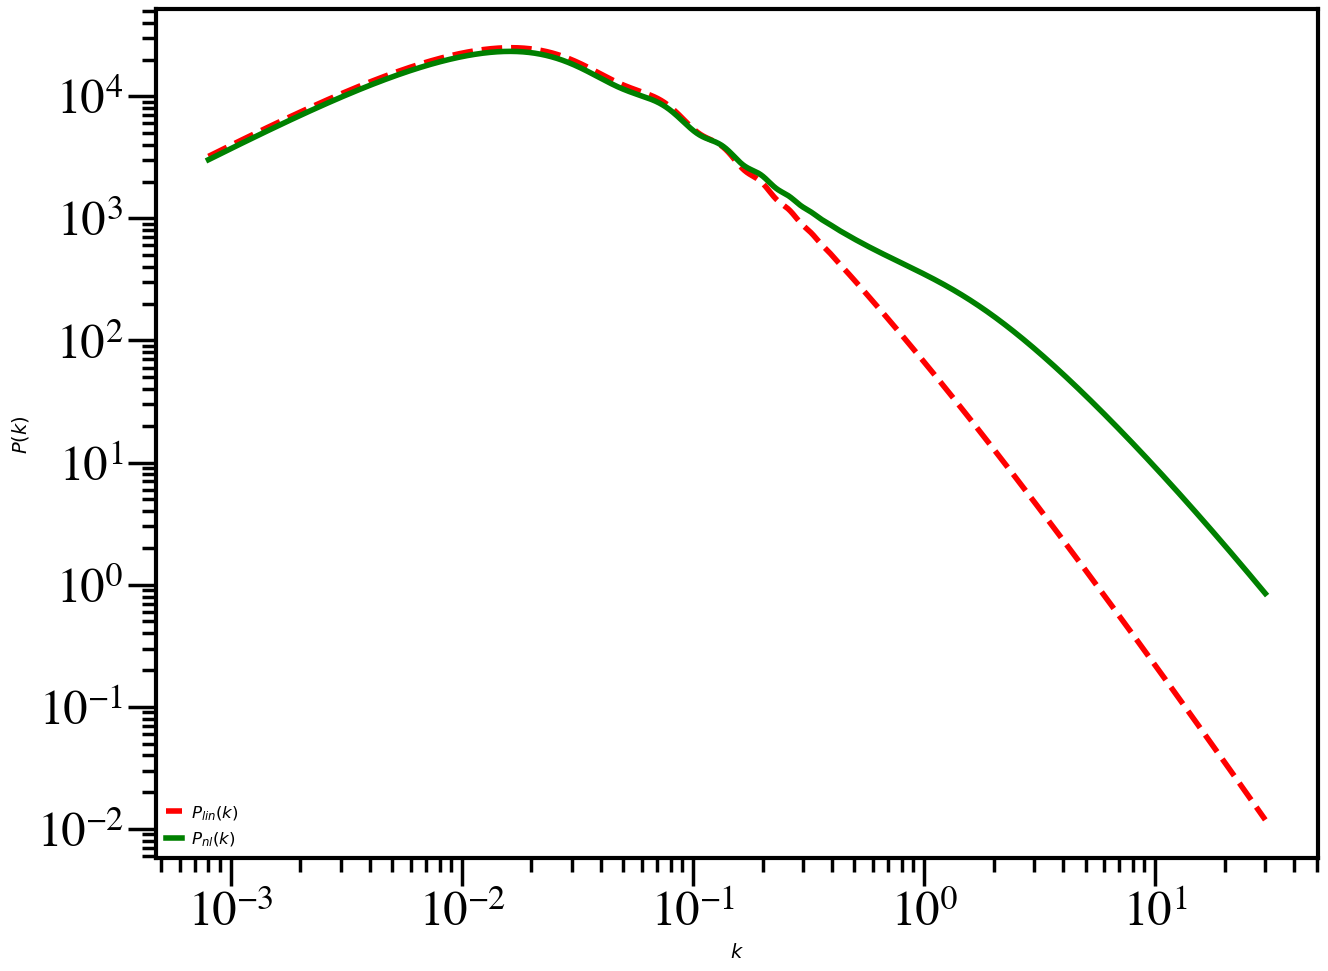

In [22]:
#Plot some stuff to check
plot(kh0,pk0_lin[0], 'r--', label='$P_{lin}(k)$')
plot(kh,pk[0], 'g-', label='$P_{nl}(k)$')

xscale('log')
yscale('log')
xlabel('$k$', fontsize=14)
ylabel('$P(k)$', fontsize=14)
legend(loc='lower left', fontsize=12, frameon=False)

In [23]:
# Initialize FASTPT object

do_IA = True
to_do = []
if do_IA:
    to_do.append('IA')
#Ideally, the initialization happens once per likelihood evaluation, or even once per chain.
pad_factor=1
low_extrap=-5
high_extrap=3
P_window=None
C_window=.75

n_pad = pad_factor*len(kh0)

fpt_obj=fpt.FASTPT(kh0,to_do=to_do,low_extrap=low_extrap,high_extrap=high_extrap,n_pad=n_pad)

In [24]:
#??fpt_obj.IA_tt

# This is a CCL function. Will need to be updated
def translate_IA_norm(cosmo, z, a1=1.0, a1delta=None, a2=None,
                      Om_m2_for_c2=False, Om_m_fid=0.3):
    """
    Function to convert from a_ia values to c_ia values,
    using the standard convention of Blazek 2019 or the variant used
    by the Dark Energy Survey analysis.

    Args:
        cosmo (:class:`~pyccl.core.Cosmology`): cosmology object.
        z (float or array_like): z value(s) where amplitude is evaluated
        a1 (float or array_like): IA a1 at input z values. Defaults to 1.0
        a1delta (float or array_like): IA a1delta at input z values.
            Defaults to None.
        a2 (float or array_like): IA a2 at input z values.
            Defaults to None.
        Om_m2_for_c2 (bool): True to use the Blazek 2019 convention of
            Om_m^2 scaling. Defaults to False
        Om_m_fid (float): Value for Blazek 2019 scaling. Defaults to 0.3.

    Returns:
        c1 (float or array_like): IA c1 at input z values
        c1delta (float or array_like): IA c1delta at input z values
        c2 (float or array_like): IA c2 at input z values
    """

    def check_input_array(a, name):
        if a is None:
            return

        if np.ndim(a) > 1:
            raise ValueError(name +
                             " should be a scalar or 1D")

        if np.ndim(a) == 1:
            if len(a) != len(z):
                raise ValueError("Both z and " + name +
                                 " should have the same size")

    if np.ndim(z) > 1:
        raise ValueError("z should be a scalar or 1D")
    check_input_array(a1, 'a1')
    check_input_array(a2, 'a2')
    check_input_array(a1delta, 'a1delta')

    Om_m = cosmo['Omega_m']
    rho_crit = lib.cvar.constants.RHO_CRITICAL
    c1 = c1delta = c2 = None
    gz = growth_factor(cosmo, 1./(1+z))

    if a1 is not None:
        c1 = -1*a1*5e-14*rho_crit*Om_m/gz

    if a1delta is not None:
        c1delta = -1*a1delta*5e-14*rho_crit*Om_m/gz

    if a2 is not None:
        if Om_m2_for_c2:  # Blazek2019 convention
            c2 = a2*5*5e-14*rho_crit*Om_m**2/(Om_m_fid*gz**2)
        else:  # DES convention
            c2 = a2*5*5e-14*rho_crit*Om_m/(gz**2)

    return c1, c1delta, c2

In [25]:
# Calculate TATT IA terms
IA_terms={}
# IA_tt = fpt_obj.IA_tt(pklin, P_window=P_window, C_window=C_window)
# IA_terms['tt_EE'] = Dz2 ** 2 * IA_tt[0] #don't need EE/BB terms for now. Will need them for ++, xx
# IA_terms['tt_BB'] = Dz2 ** 2 * IA_tt[1]
IA_ta = fpt_obj.IA_ta(pklin, P_window=P_window, C_window=C_window)
IA_terms['ta_dE1'] = Dz2 ** 2 * IA_ta[0]
IA_terms['ta_dE2'] = Dz2 ** 2 * IA_ta[1]
# IA_terms['ta_EE'] = Dz2 ** 2 * IA_ta[2]
# IA_terms['ta_BB'] = Dz2 ** 2 * IA_ta[3]
IA_mix = fpt_obj.IA_mix(pklin, P_window=P_window, C_window=C_window)
IA_terms['mix_A'] = Dz2 ** 2 * IA_mix[0]
IA_terms['mix_B'] = Dz2 ** 2 * IA_mix[1]
# IA_terms['mix_D_EE'] = Dz2 ** 2 * IA_mix[2]
# IA_terms['mix_D_BB'] = Dz2 ** 2 * IA_mix[3]


Eventually, we should switch to CCL functionality.

In [26]:
# Calculate TATT IA terms
IA_terms_w={}
IA_terms_w_intp={}
taper=False
for i in IA_terms.keys():
    rp_gp, IA_terms_w[i]=HT.projected_correlation(k_pk=kh,pk=IA_terms[i],j_nu=2,taper=taper)
    #IA_terms_w[i]=IA_terms_w[i]*wgp_f #the factor is now applied later
    IA_terms_w_intp[i]=interp1d(rp_gp,IA_terms_w[i],bounds_error=False, fill_value=0)

No handles with labels found to put in legend.


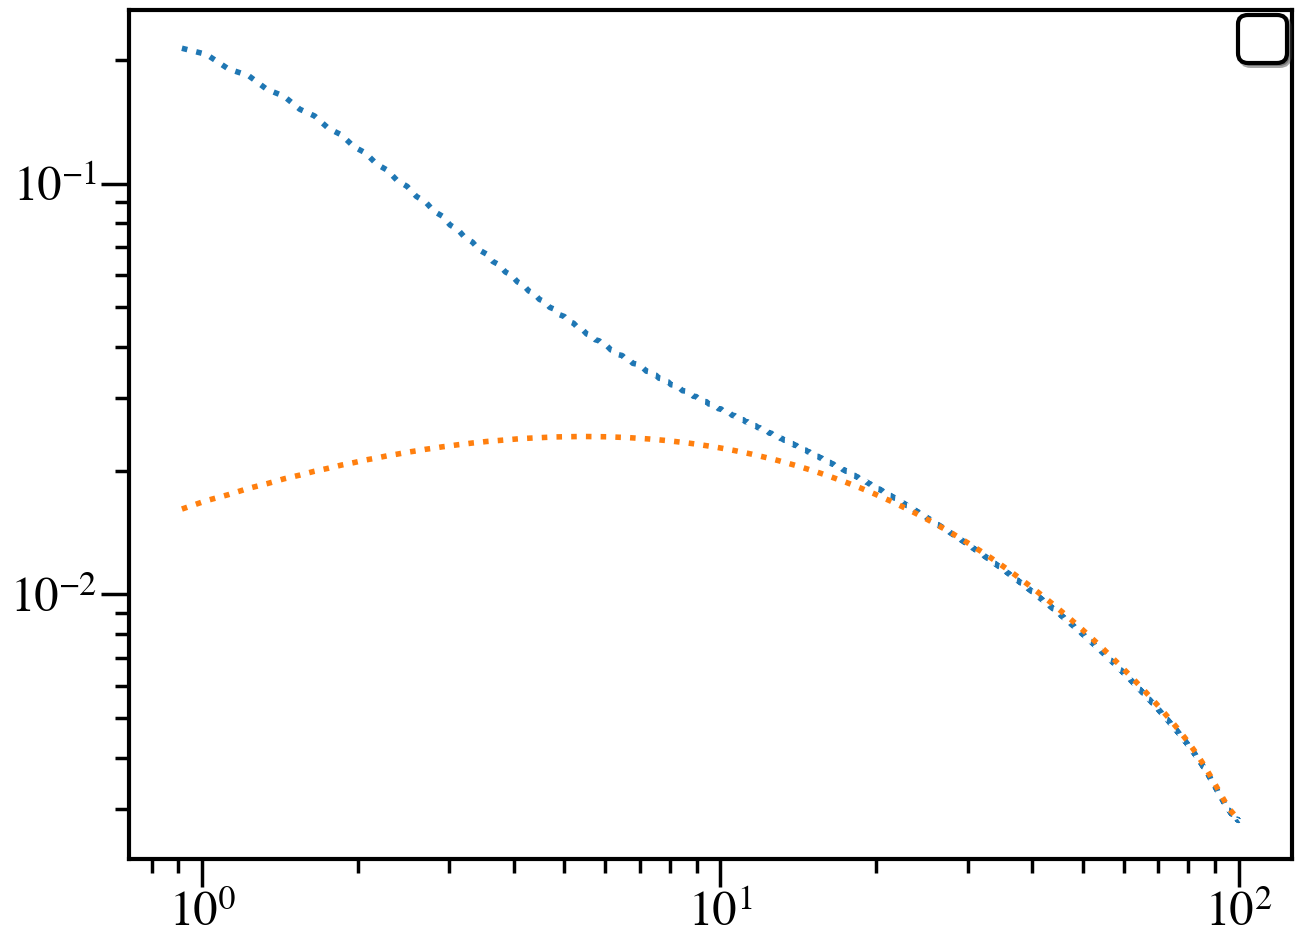

In [27]:
for i in IA_terms.keys():
    if not 'tt' in i:
        continue
    plot(rp_gp, IA_terms_w[i],label=i)
plot(r_gp,wgp,':')
plot(r_gp,wgp_lin,':')
loglog()
legend()

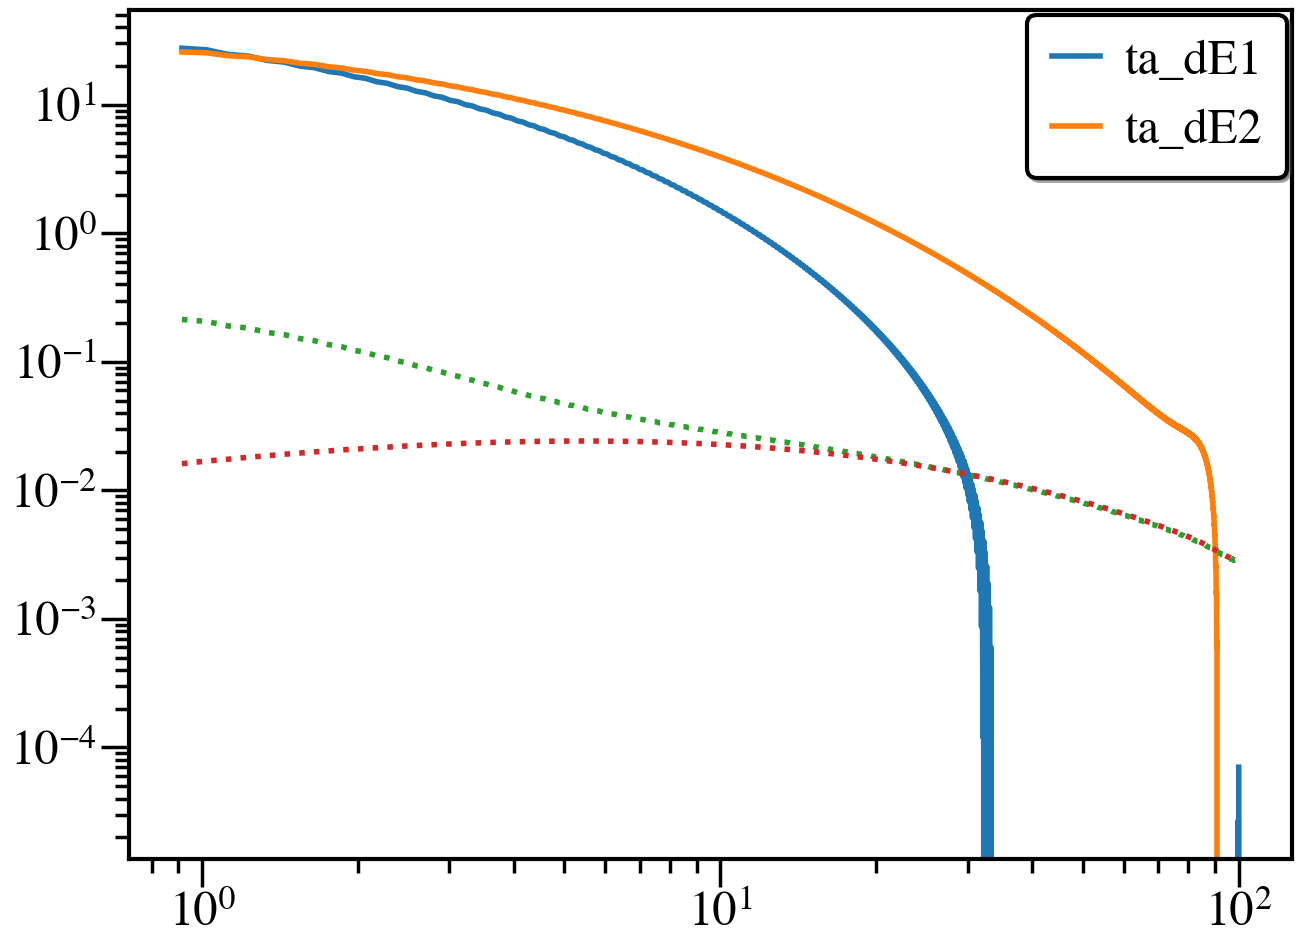

In [28]:
for i in IA_terms.keys():
    if not 'ta' in i:
        continue
    plot(rp_gp, IA_terms_w[i],label=i)
plot(r_gp,wgp,':')
plot(r_gp,wgp_lin,':')
loglog()
legend()

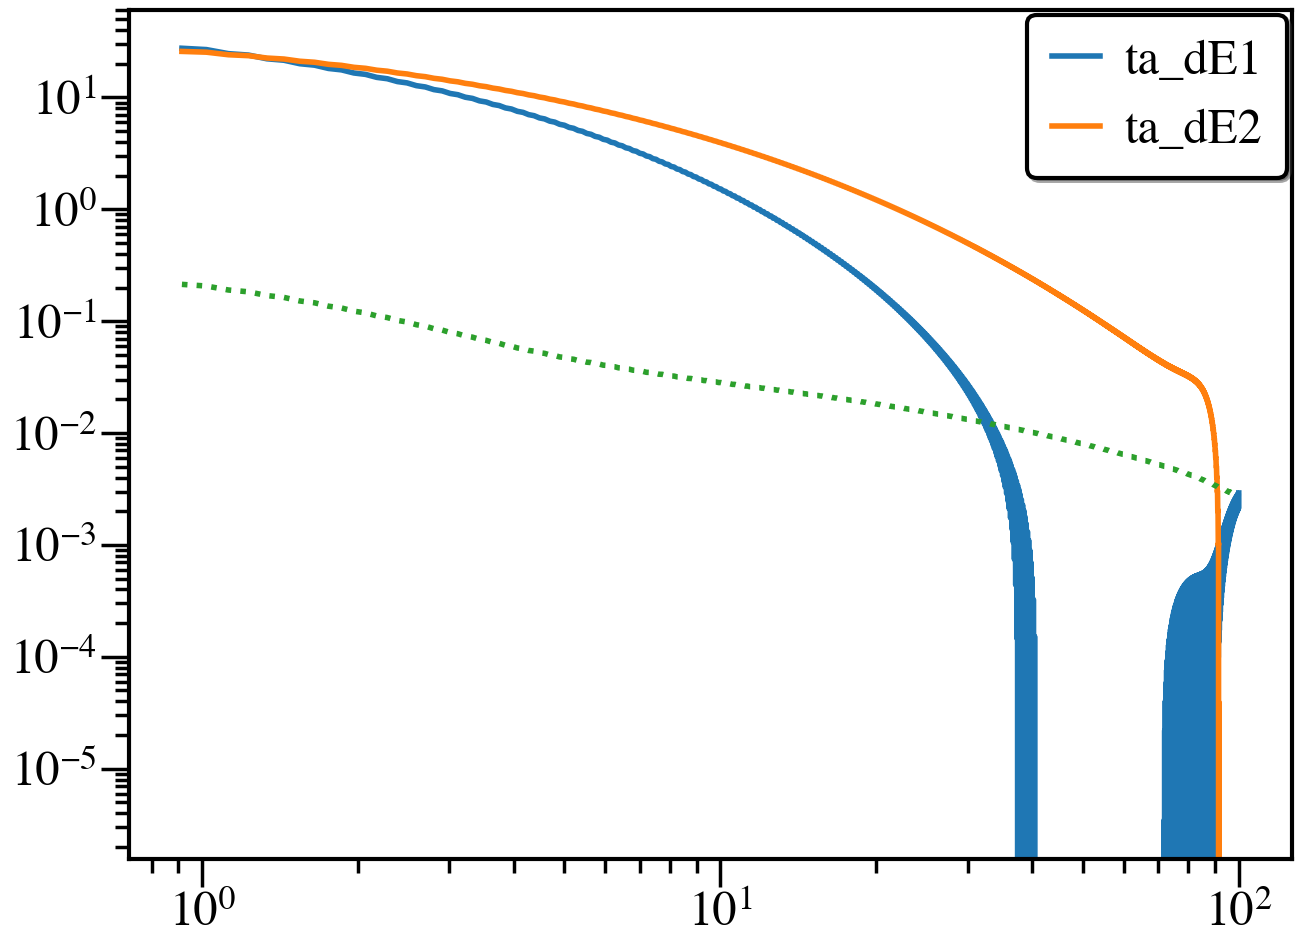

In [29]:
for i in IA_terms.keys():
    if not 'ta' in i:
        continue
    plot(rp_gp, IA_terms_w[i]+wgp_lin,label=i)
plot(r_gp,wgp,':')
# plot(r_gp,wgp_lin,':')
loglog()
legend()

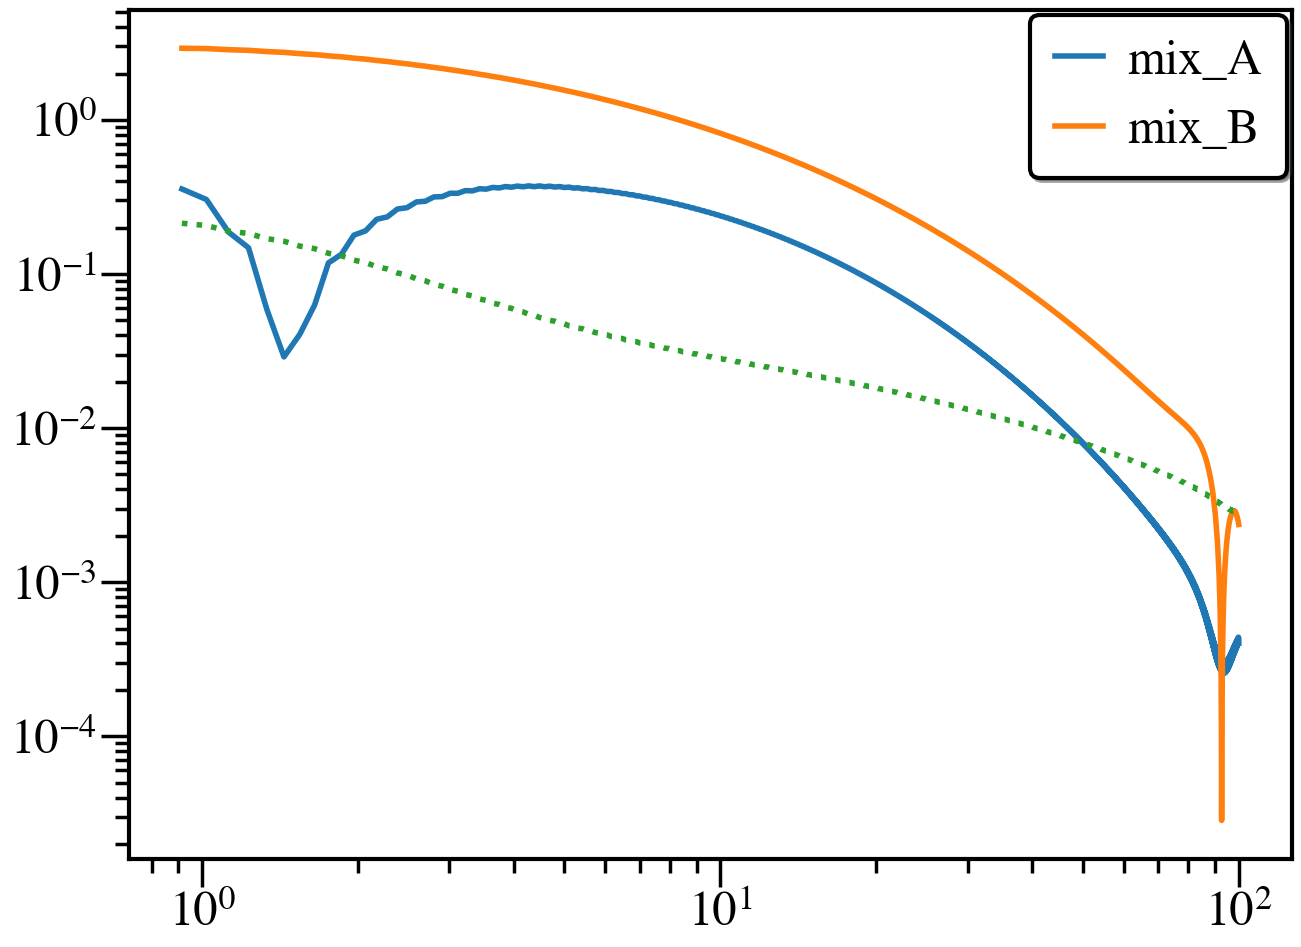

In [30]:
for i in IA_terms.keys():
    if not 'mix' in i:
        continue
    plot(rp_gp, np.absolute(IA_terms_w[i]),label=i)
plot(r_gp,wgp,':')
loglog()
legend()

In [31]:
priors={'bg':[0,5], 'AI':[-50,50],'b_tatt':[-100,100],'A2':[-100,100]}

In [32]:
burn_in=2000
nwalkers=100
n_step=6000+burn_in

acceptance_fraction 0.71358875
0 chisq : [5.22229084] [2.7468649] [2.47542594]
$r_p$$w_{g+}$ [Mpc/h]$^2$


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


0

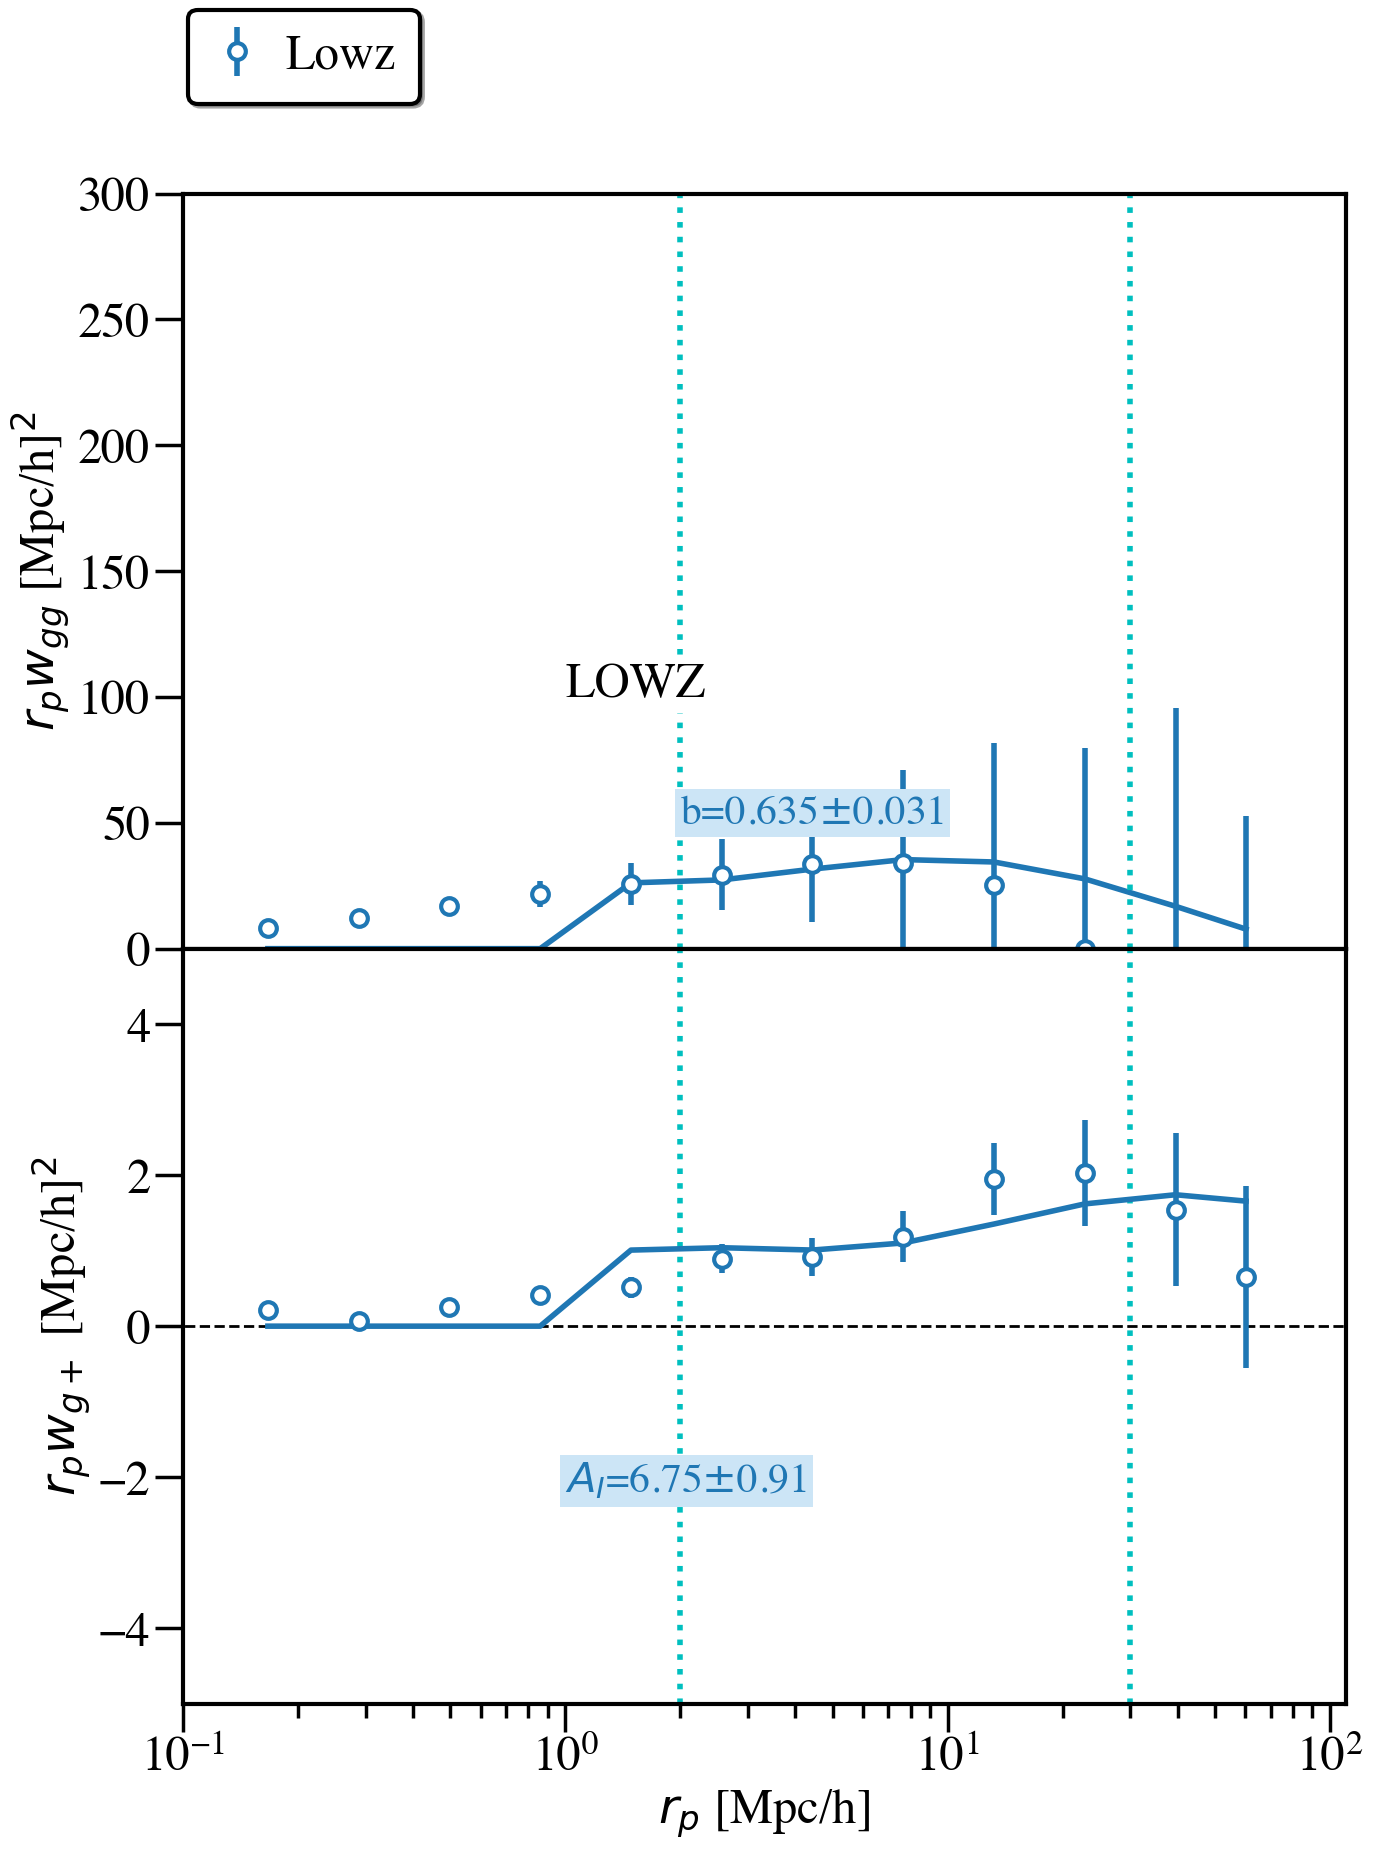

In [33]:
hm='./data_out/tenneti/data_tidal_wgp/data_out/'
fn='1tidal_1'
DI[fn]=mcmc_dat(home=hm,dataset=fn,corr='ia',lbl='Lowz',diag_cov=True,use_tatt_model=False,rp_min=2,read_jk=False,
               burn_in=burn_in,nwalkers=nwalkers,n_step=n_step)

# fns=['1tidal_0']
# ds={i:DI[fns[i]] for i in np.arange(len(fns))}
ds={0:DI[fn]}
plot_corrs(datasets=ds,wgg_ylim=(0.e2,3e2),wgp_ylim=(-5,5),db_y=40,b_y=50,b_x=2,A_y=-2.2,A_x=1,dA_y=.8,legend_loc=(0, 1.25),legend_col=2,text_info='LOWZ',ti_x=1,ti_y=100)

In [34]:
DI_tatt={}

In [35]:
hm='./data_out/tenneti/data_tidal_wgp/data_out/'
fns=['{i}tidal_1'.format(i=i) for i in np.arange(4)+1]
fns+=['{i}tidal_5'.format(i=i) for i in np.arange(3)+1]
fns+=['{i}tidal_0'.format(i=i) for i in np.arange(3)+1]

dlabels=[r'$M_{i}\Gamma_+$'.format(i=i) for i in np.arange(4)+1]
dlabels[-1]=r'$\Gamma_+$'
dlabels+=[r'$M_{i}\Gamma^s_+$'.format(i=i) for i in np.arange(3)+1]
# dlabels[-1]=r'$\Gamma^s_+$'
dlabels+=[r'$M_{i}\gamma_+$'.format(i=i) for i in np.arange(4)+1]
j=0
print(fn,'done')
for fn in fns:
    try:
        DI[fn]=mcmc_dat(home=hm,dataset=fn,corr='ia',lbl=dlabels[j],diag_cov=True,use_tatt_model=False,rp_min=2,read_jk=False,
               burn_in=burn_in,nwalkers=nwalkers,n_step=n_step)
        D_tatt[fn]=mcmc_dat(home=hm,dataset=fn,corr='ia',lbl=dlabels[j],diag_cov=True,use_tatt_model=True,rp_min=2,read_jk=False,
               burn_in=burn_in,nwalkers=nwalkers,n_step=n_step)
    except Exception as err:
        print(err)
    j+=1


1tidal_1 done
acceptance_fraction 0.7136187500000001
acceptance_fraction 0.59321125
acceptance_fraction 0.69384125
acceptance_fraction 0.53955125
acceptance_fraction 0.6744287500000001
acceptance_fraction 0.45496624999999996
acceptance_fraction 0.6829249999999999
acceptance_fraction 0.493015
acceptance_fraction 0.7128912500000001
acceptance_fraction 0.5922949999999999
acceptance_fraction 0.6973174999999999
acceptance_fraction 0.5821350000000001
acceptance_fraction 0.7130937500000002
acceptance_fraction 0.5927825000000001
acceptance_fraction 0.7130262500000001
acceptance_fraction 0.5709449999999999
acceptance_fraction 0.7127475000000001
acceptance_fraction 0.5938399999999999
acceptance_fraction 0.71314875
acceptance_fraction 0.59309375


In [36]:
DI5={}
D5_tatt={}

In [37]:
hm='./data_out/tenneti/data_tidal_wgp/data_out/'
fns=['{i}tidal_1'.format(i=i) for i in np.arange(4)+1]
fns+=['{i}tidal_5'.format(i=i) for i in np.arange(3)+1]
fns+=['{i}tidal_0'.format(i=i) for i in np.arange(3)+1]

dlabels=[r'$M_{i}\Gamma_+$'.format(i=i) for i in np.arange(4)+1]
dlabels[-1]=r'$\Gamma_+$'
dlabels+=[r'$M_{i}\Gamma^s_+$'.format(i=i) for i in np.arange(3)+1]
# dlabels[-1]=r'$\Gamma^s_+$'
dlabels+=[r'$M_{i}\gamma_+$'.format(i=i) for i in np.arange(4)+1]
j=0
for fn in fns:
    try:
        DI5[fn]=mcmc_dat(home=hm,dataset=fn,corr='ia',lbl=dlabels[j],diag_cov=True,use_tatt_model=False,rp_min=5,read_jk=False,
               burn_in=burn_in,nwalkers=nwalkers,n_step=n_step)
        D5_tatt[fn]=mcmc_dat(home=hm,dataset=fn,corr='ia',lbl=dlabels[j],diag_cov=True,use_tatt_model=True,rp_min=5,read_jk=False,
               burn_in=burn_in,nwalkers=nwalkers,n_step=n_step)
    except Exception as err:
        print(err)
    print(fn,'done')
    j+=1



acceptance_fraction 0.7123837499999999
acceptance_fraction 0.5848825
1tidal_1 done
acceptance_fraction 0.6811499999999999
acceptance_fraction 0.50617125
2tidal_1 done
acceptance_fraction 0.6737512500000001
acceptance_fraction 0.43652499999999994
3tidal_1 done
acceptance_fraction 0.6776425
acceptance_fraction 0.53162125
4tidal_1 done
acceptance_fraction 0.7113775000000001
acceptance_fraction 0.590315
1tidal_5 done
acceptance_fraction 0.71162375
acceptance_fraction 0.59133875
2tidal_5 done
acceptance_fraction 0.7124312500000001
acceptance_fraction 0.5922499999999999
3tidal_5 done
acceptance_fraction 0.7124100000000001
acceptance_fraction 0.5920725
1tidal_0 done
acceptance_fraction 0.71251375
acceptance_fraction 0.5878349999999999
2tidal_0 done
acceptance_fraction 0.7118587500000001
acceptance_fraction 0.5521450000000001
3tidal_0 done


In [38]:
for fn in fns:
    rp=DI[fn]['dat_cut']['data']['1bin_value']
    dof=len(rp)
    print(fn,DI[fn]['chisq_gm']/(dof-1),D_tatt[fn]['chisq_gm']/(dof-3))
    print(fn,5,DI5[fn]['chisq_gm']/(dof-1),D5_tatt[fn]['chisq_gm']/(dof-3))

1tidal_1 [0.61885632] [0.12300263]
1tidal_1 5 [0.14500313] [0.0017878]
2tidal_1 [0.41885529] [0.00513926]
2tidal_1 5 [0.20484679] [0.00011351]
3tidal_1 [1.63888366] [1.19630381]
3tidal_1 5 [0.16228214] [0.10937004]
4tidal_1 [0.19275874] [0.0530947]
4tidal_1 5 [0.05049916] [0.00160131]
1tidal_5 [0.24872588] [0.18284969]
1tidal_5 5 [0.24035402] [0.0021924]
2tidal_5 [0.29991653] [0.42399514]
2tidal_5 5 [0.00468395] [0.00194765]
3tidal_5 [1.45679331] [0.17371095]
3tidal_5 5 [0.39110445] [0.00051373]
1tidal_0 [3.23732335] [0.23601549]
1tidal_0 5 [0.28098957] [0.00049368]
2tidal_0 [2.0115709] [0.04644074]
2tidal_0 5 [0.13159509] [0.00232982]
3tidal_0 [1.65780357] [2.49868938]
3tidal_0 5 [0.0951469] [0.00022431]


In [39]:
fns=DI.keys()

In [43]:
DI_tatt=D_tatt

0 chisq : [5.22229062] [2.74686535] [2.47542527]
$r_p$$w_{g+}$ [Mpc/h]$^2$
1 chisq : [2.99321518] [2.74720991] [0.24600527]
$r_p$$w_{g+}$ [Mpc/h]$^2$
0 chisq : [4.42228608] [2.74686492] [1.67542116]
$r_p$$w_{g+}$ [Mpc/h]$^2$
1 chisq : [2.75873367] [2.74845516] [0.01027851]
$r_p$$w_{g+}$ [Mpc/h]$^2$
0 chisq : [9.3058407] [2.75030606] [6.55553465]
$r_p$$w_{g+}$ [Mpc/h]$^2$
1 chisq : [5.14315465] [2.75054702] [2.39260763]
$r_p$$w_{g+}$ [Mpc/h]$^2$
0 chisq : [3.51789993] [2.74686495] [0.77103497]
$r_p$$w_{g+}$ [Mpc/h]$^2$
1 chisq : [2.85738467] [2.75119526] [0.10618941]
$r_p$$w_{g+}$ [Mpc/h]$^2$


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


0 chisq : [3.74176893] [2.74686539] [0.99490354]
$r_p$$w_{g+}$ [Mpc/h]$^2$
1 chisq : [3.11259622] [2.74689683] [0.36569939]
$r_p$$w_{g+}$ [Mpc/h]$^2$
0 chisq : [3.94653197] [2.74686585] [1.19966612]
$r_p$$w_{g+}$ [Mpc/h]$^2$
1 chisq : [3.59550351] [2.74751324] [0.84799027]
$r_p$$w_{g+}$ [Mpc/h]$^2$
0 chisq : [8.57403979] [2.74686655] [5.82717324]
$r_p$$w_{g+}$ [Mpc/h]$^2$
1 chisq : [3.09461289] [2.74719098] [0.34742191]
$r_p$$w_{g+}$ [Mpc/h]$^2$
0 chisq : [15.69615963] [2.74686623] [12.9492934]
$r_p$$w_{g+}$ [Mpc/h]$^2$
1 chisq : [3.2189182] [2.74688722] [0.47203098]
$r_p$$w_{g+}$ [Mpc/h]$^2$
0

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: M

 chisq : [10.79315089] [2.7468673] [8.04628359]
$r_p$$w_{g+}$ [Mpc/h]$^2$
1 chisq : [2.83988191] [2.74700043] [0.09288147]
$r_p$$w_{g+}$ [Mpc/h]$^2$
0 chisq : [9.37807945] [2.74686517] [6.63121427]
$r_p$$w_{g+}$ [Mpc/h]$^2$
1 chisq : [7.74442186] [2.7470431] [4.99737876]
$r_p$$w_{g+}$ [Mpc/h]$^2$


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


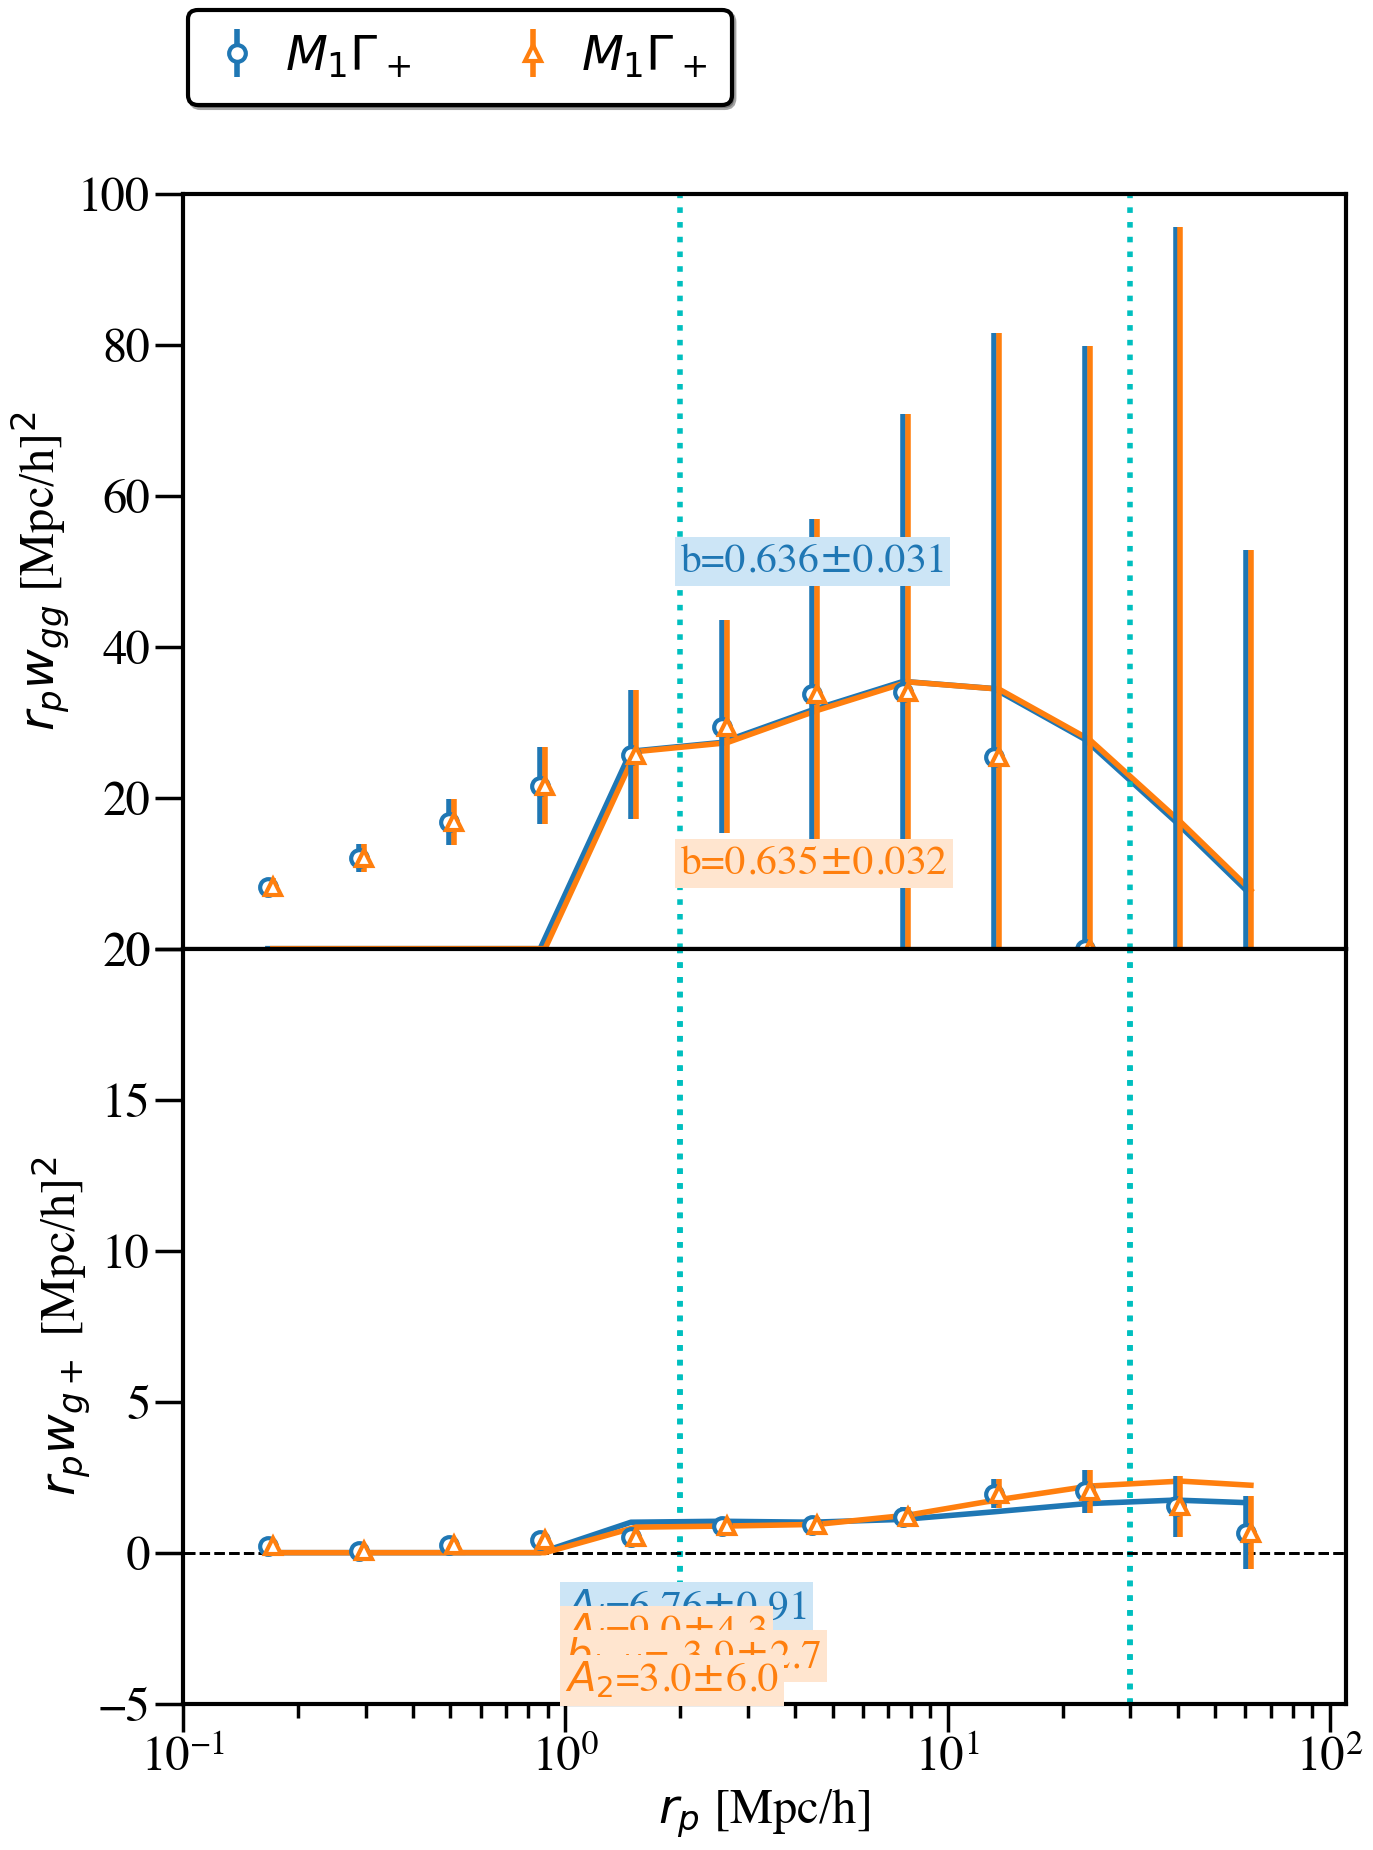

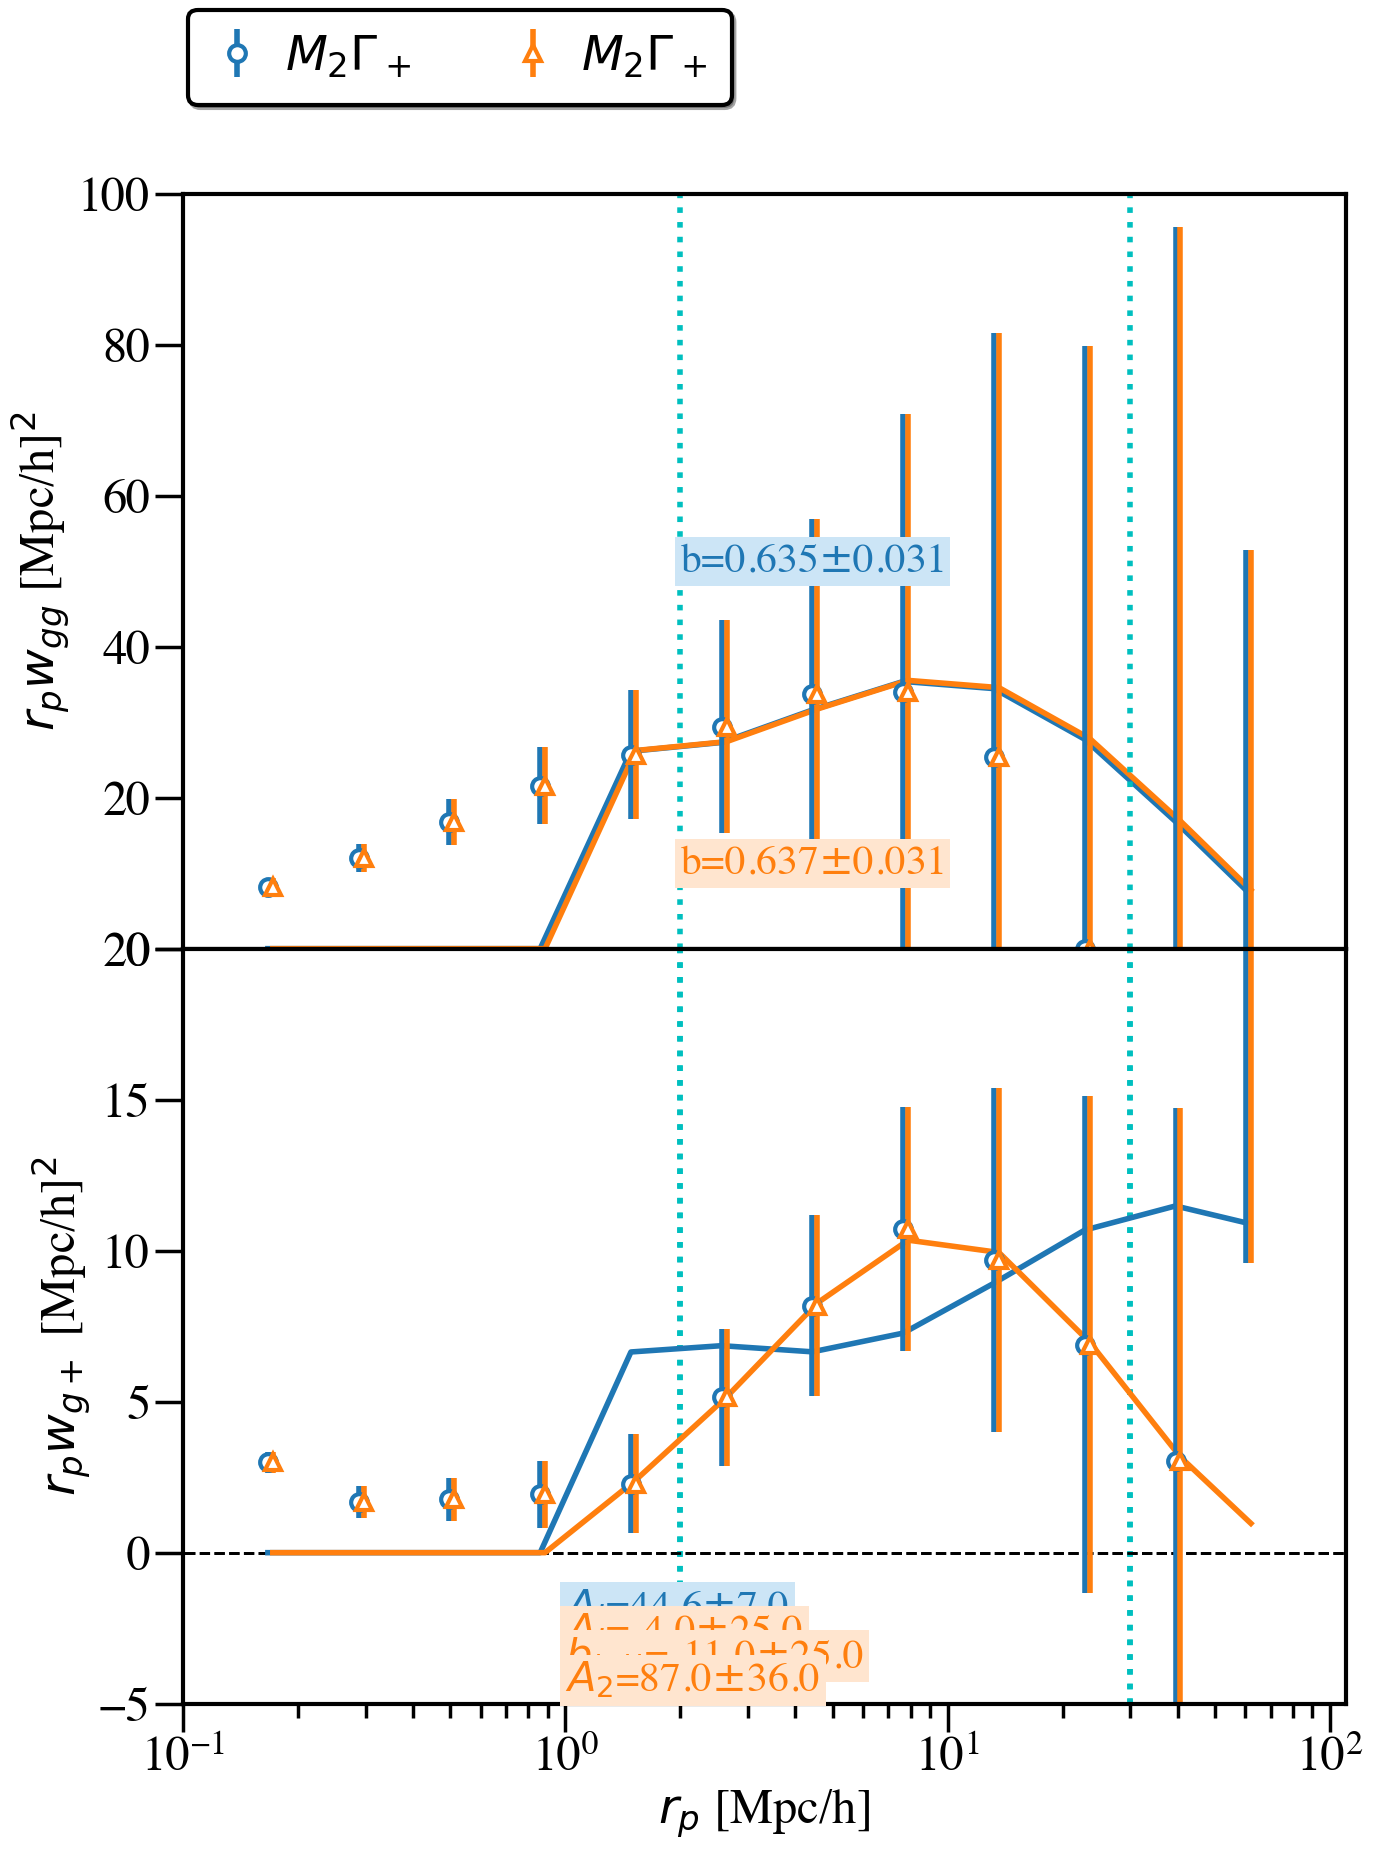

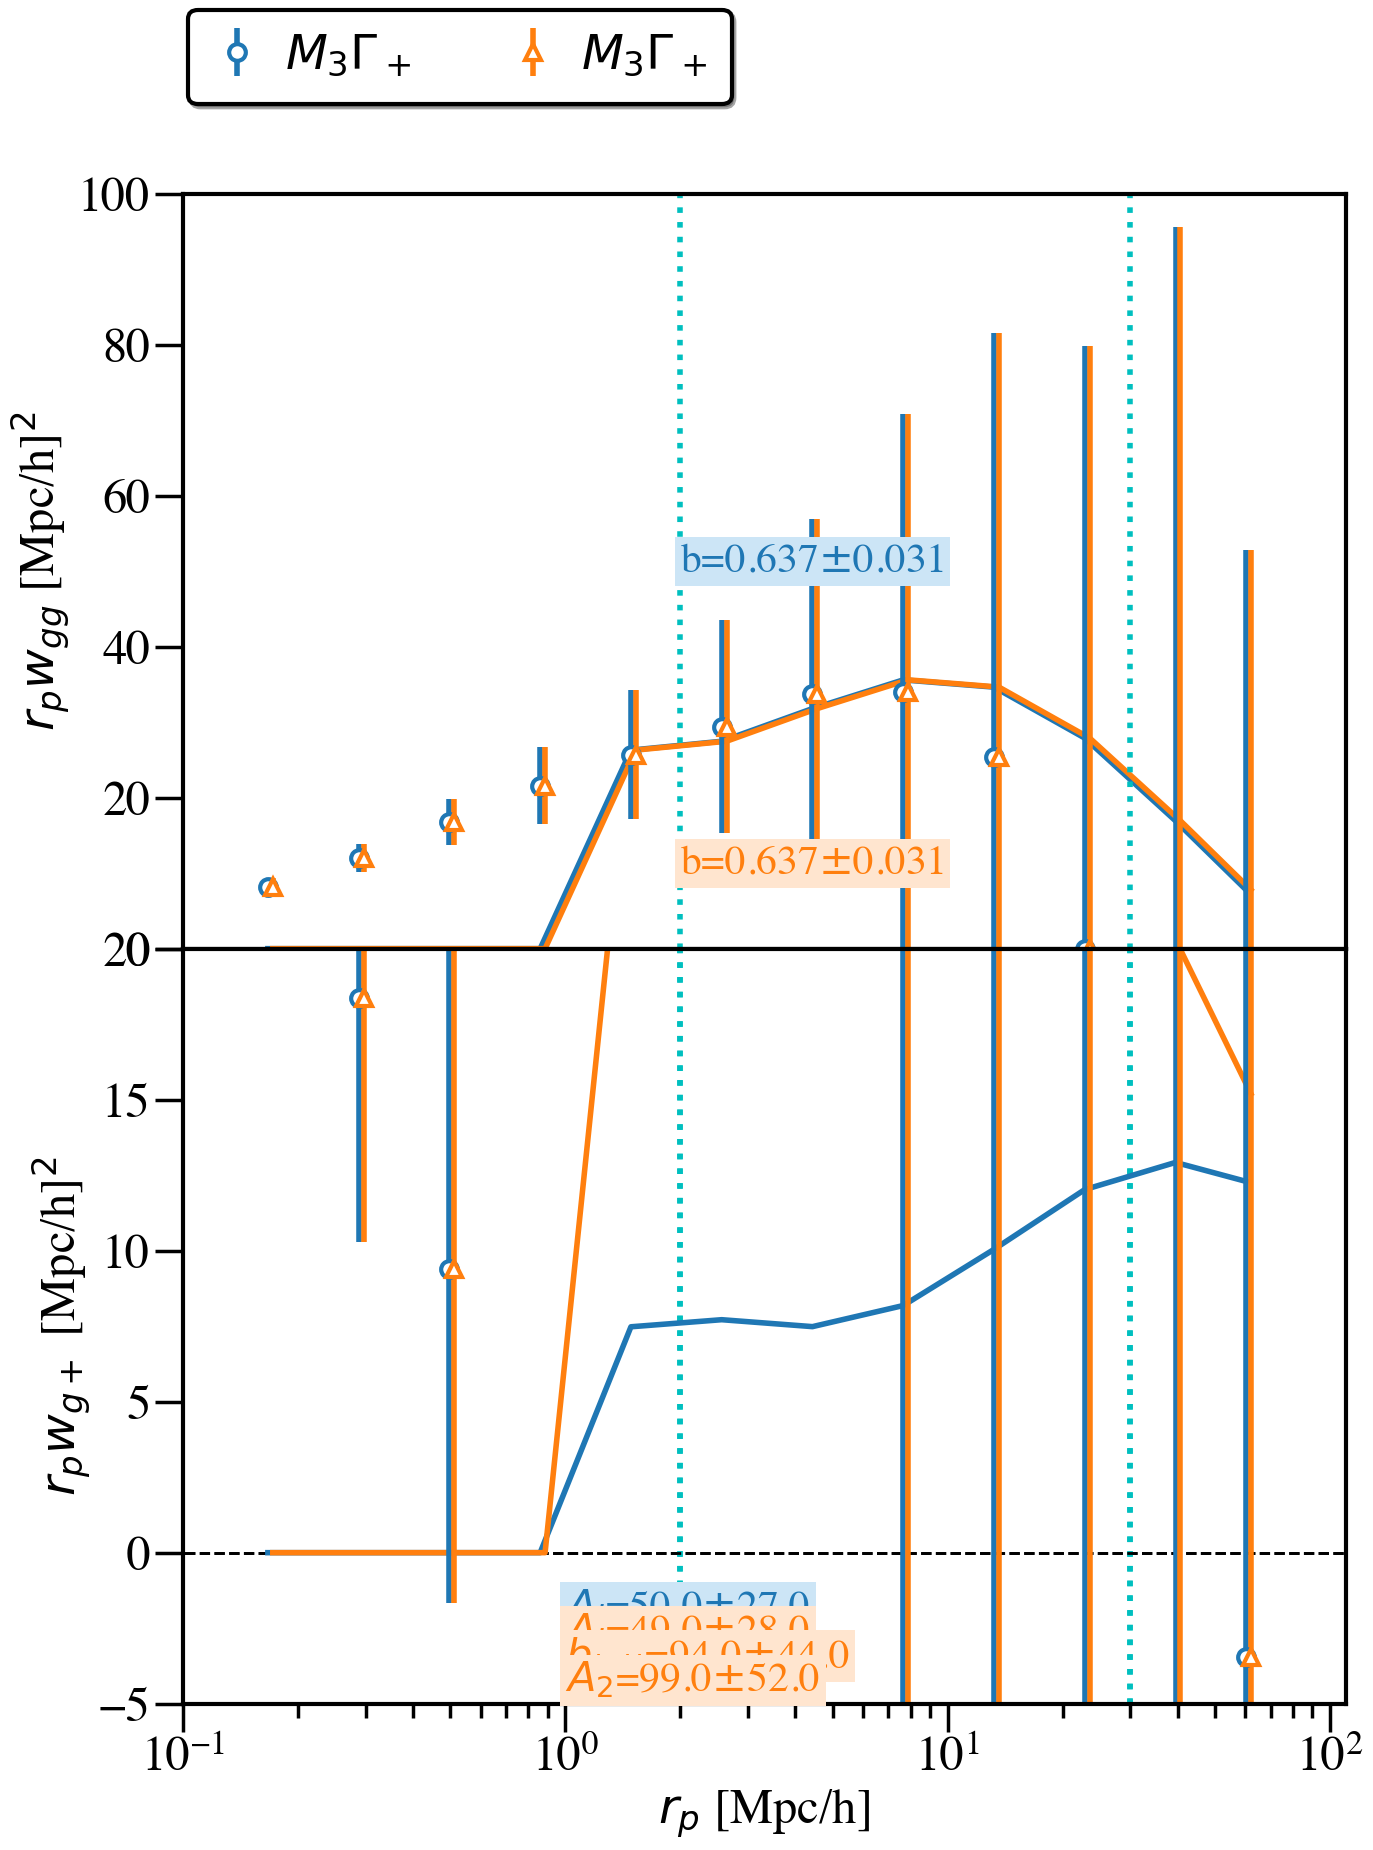

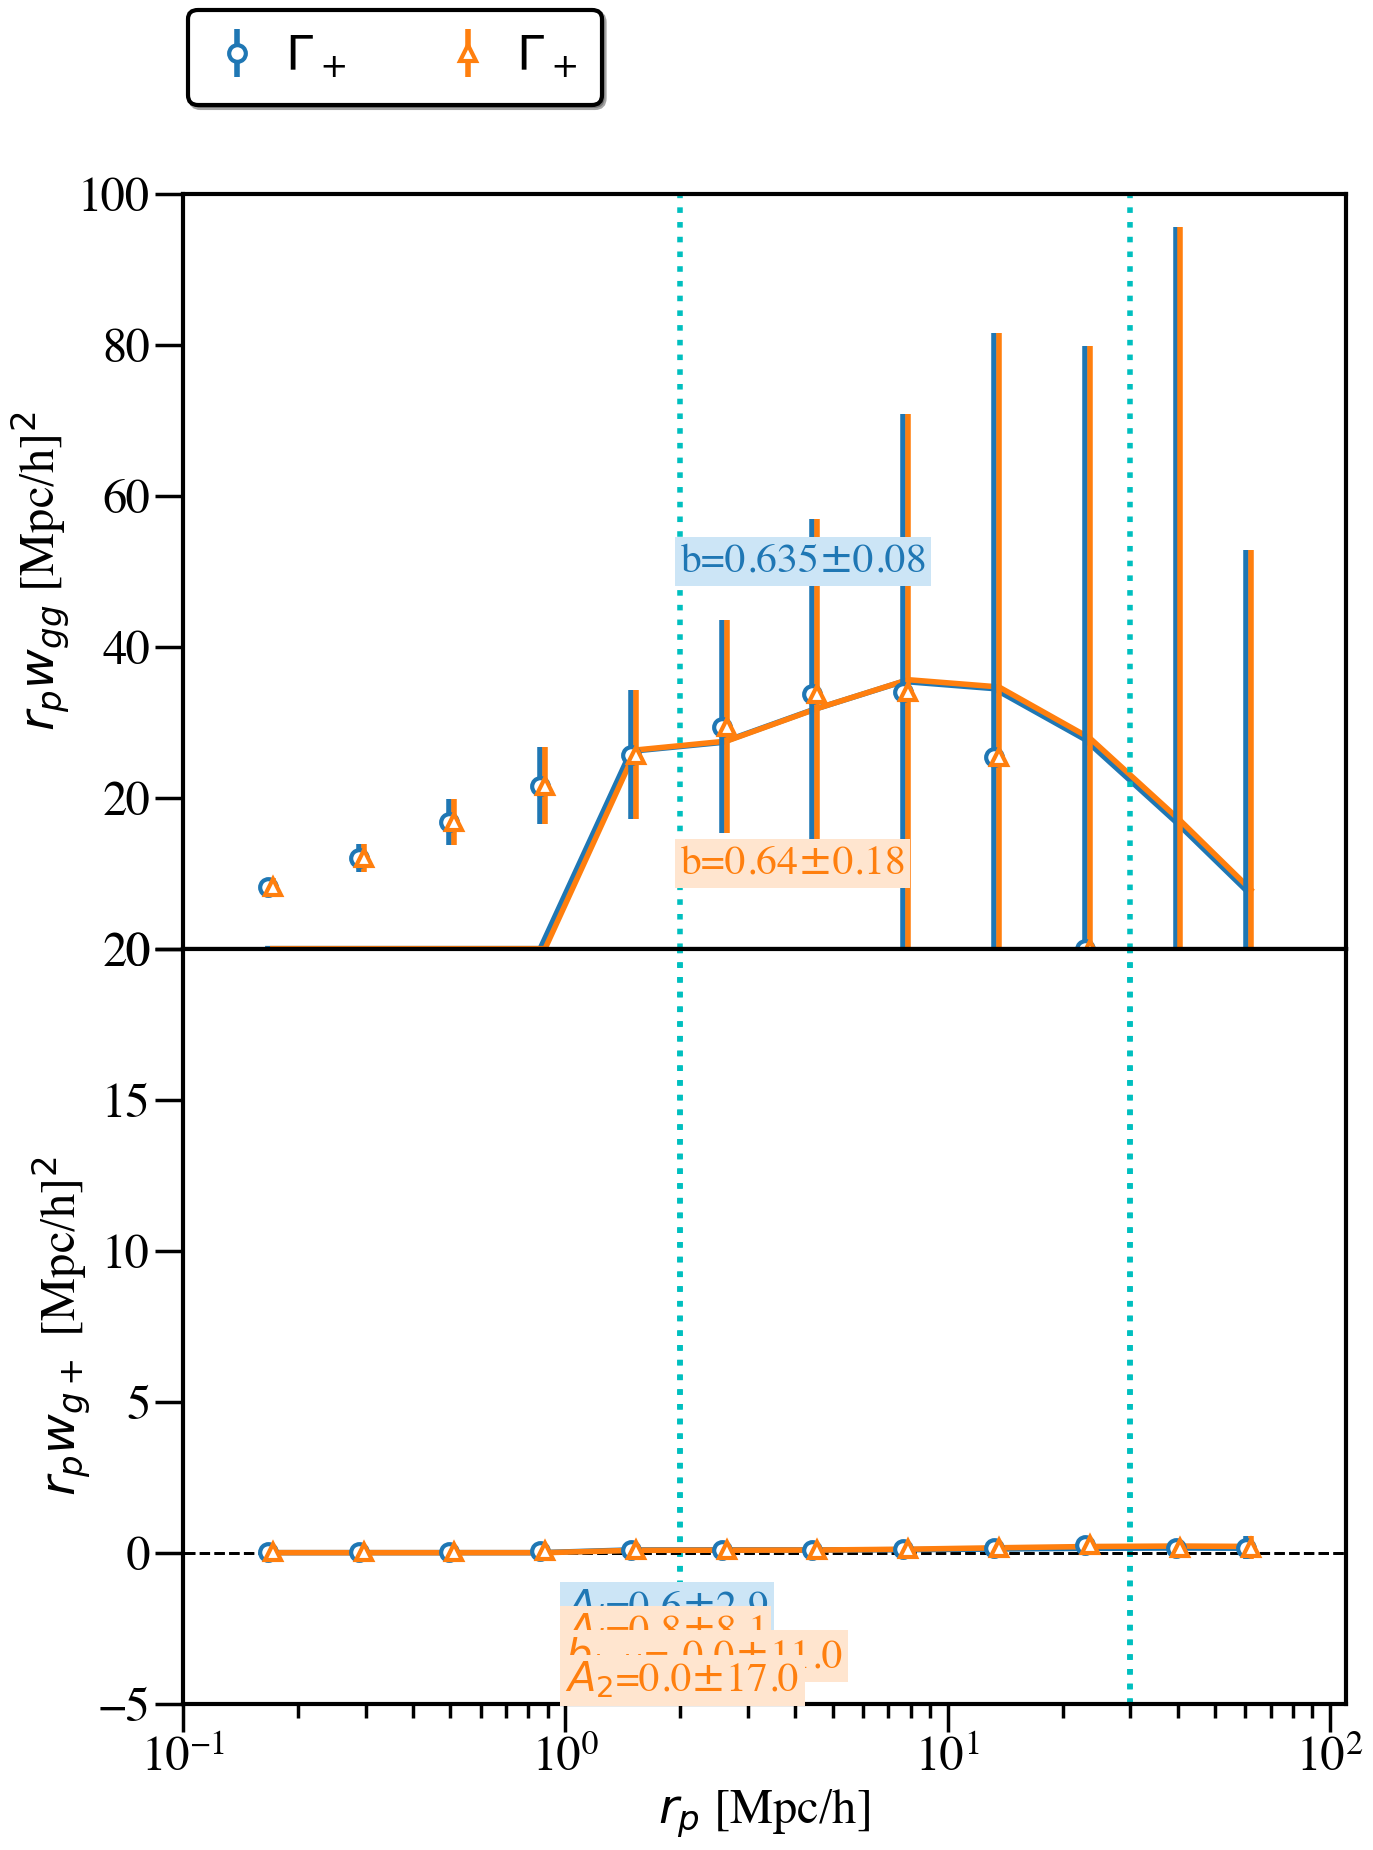

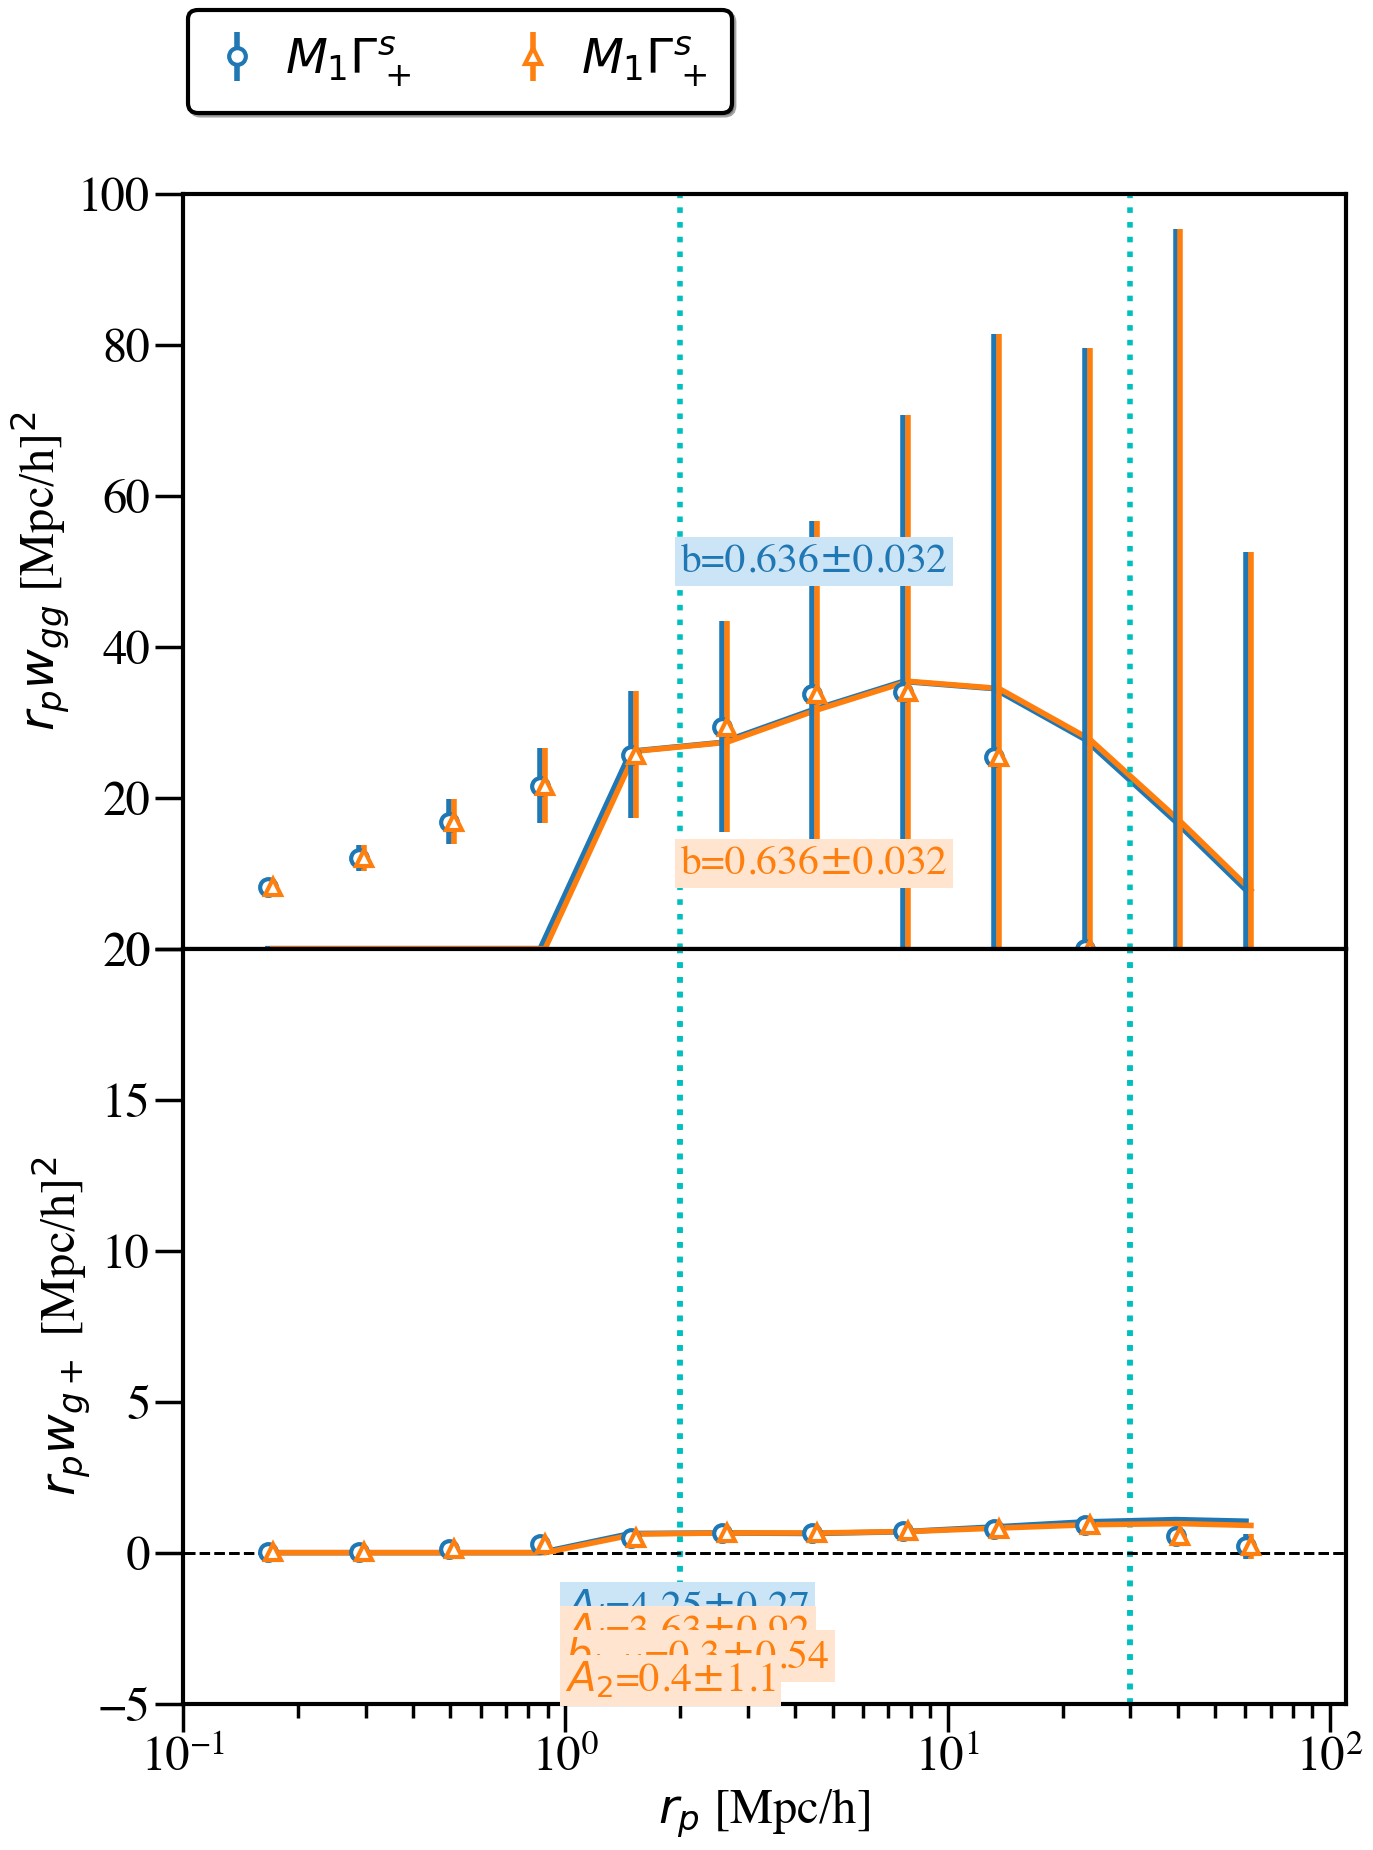

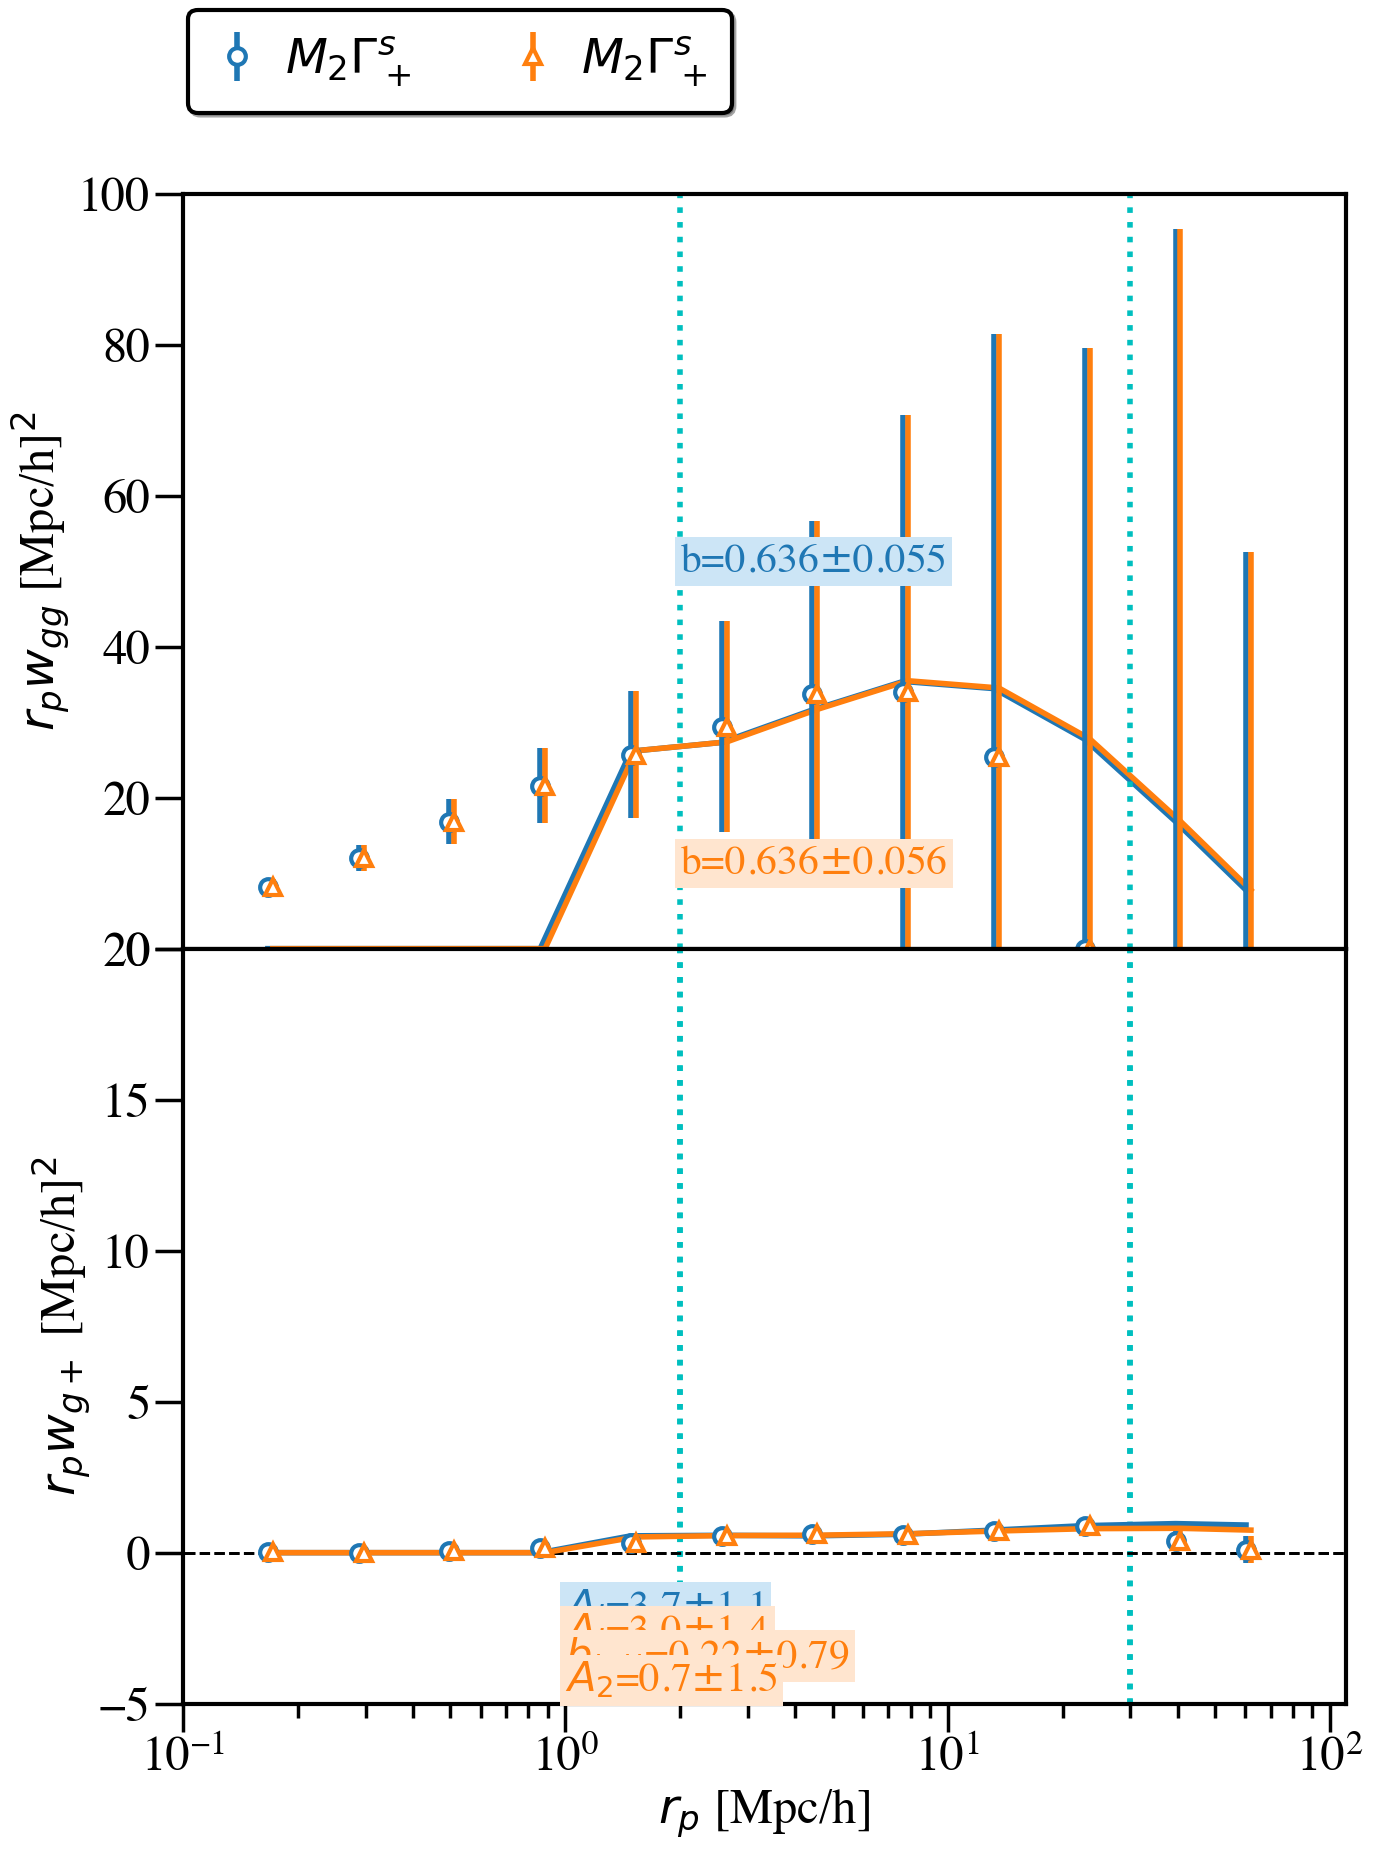

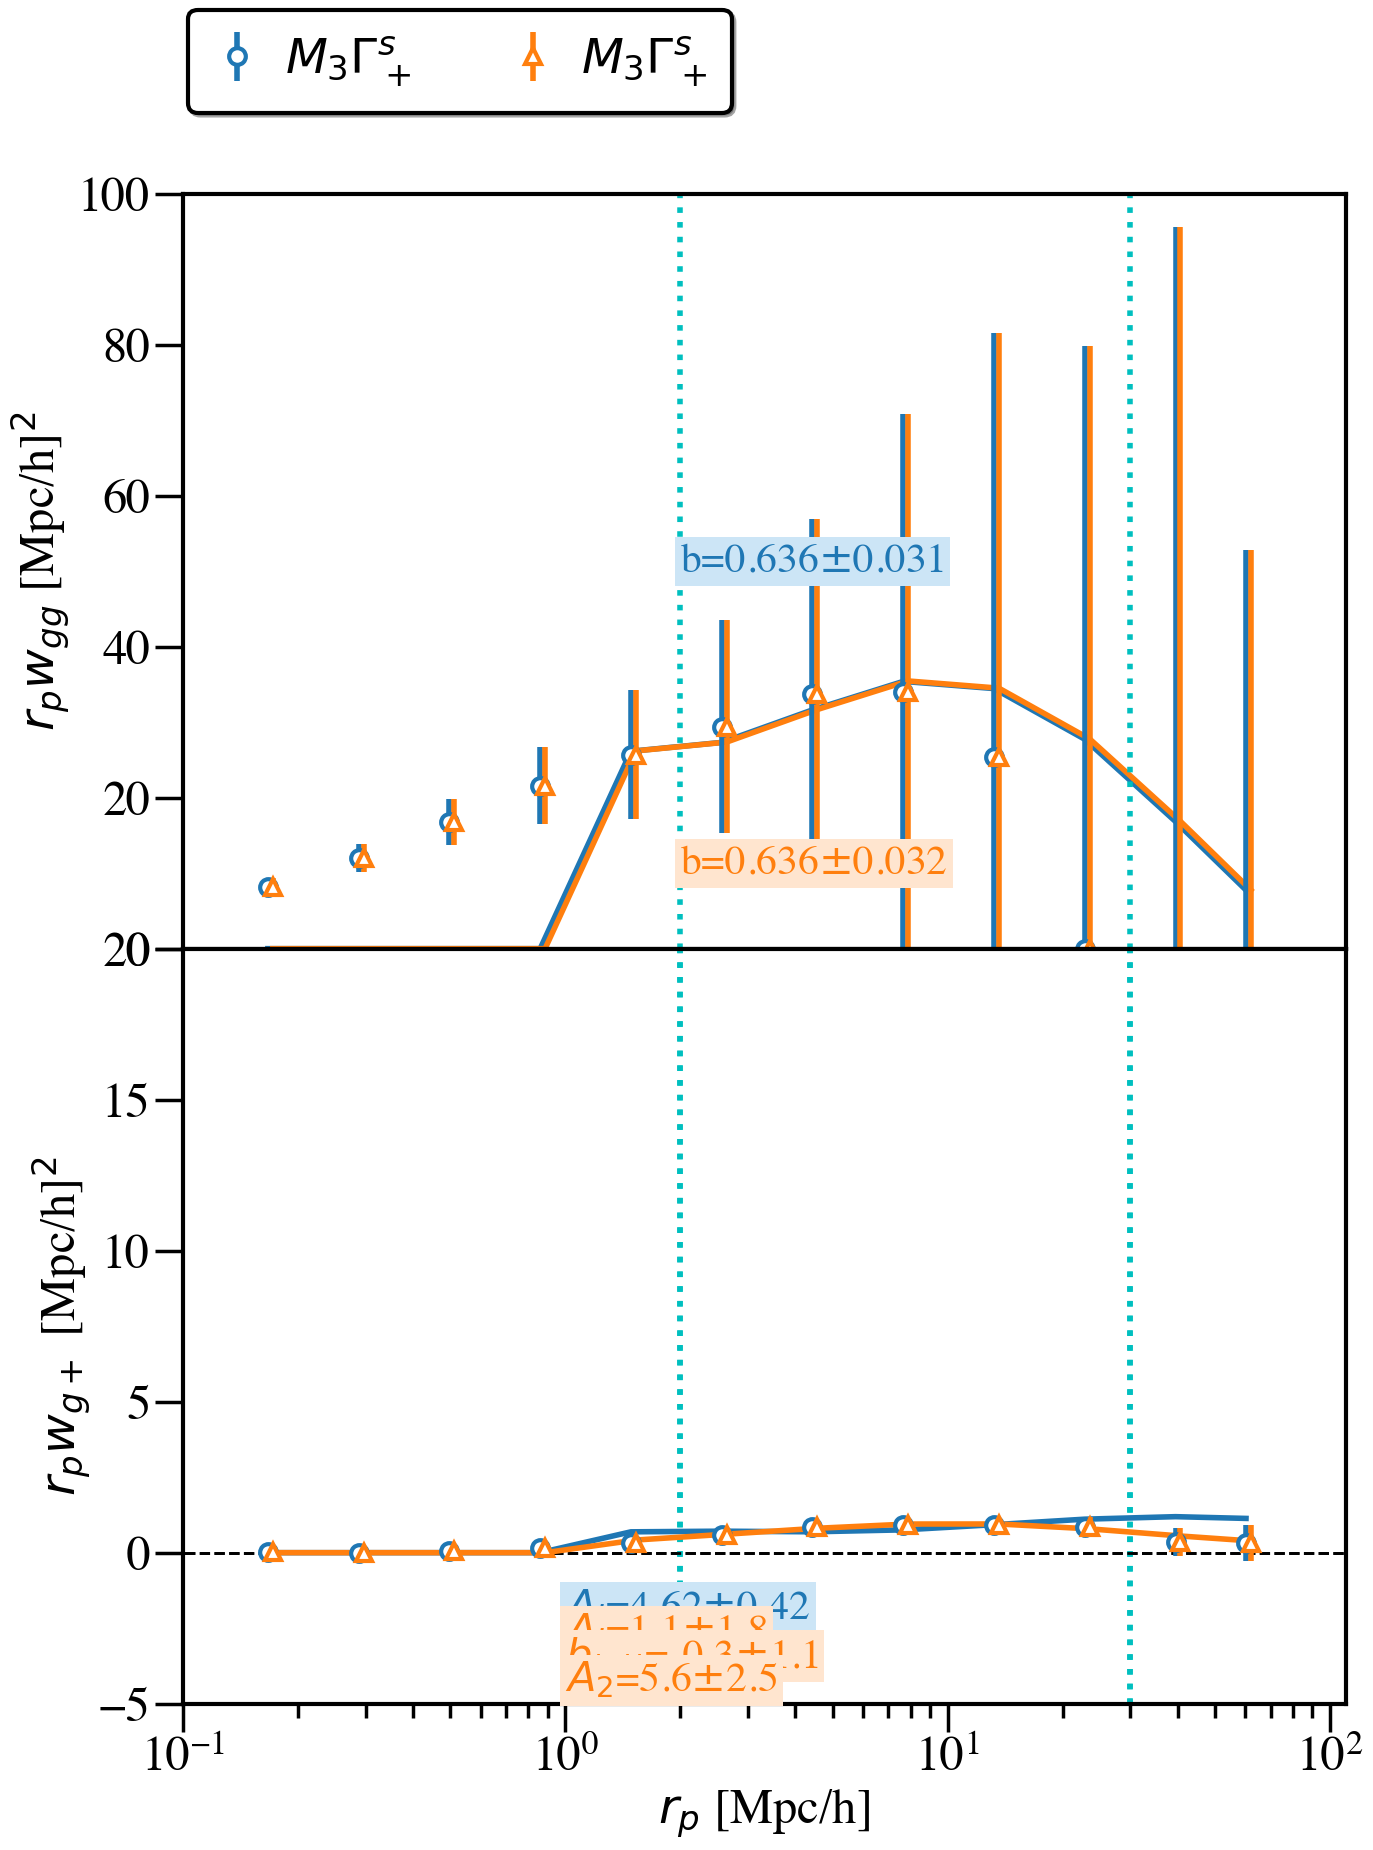

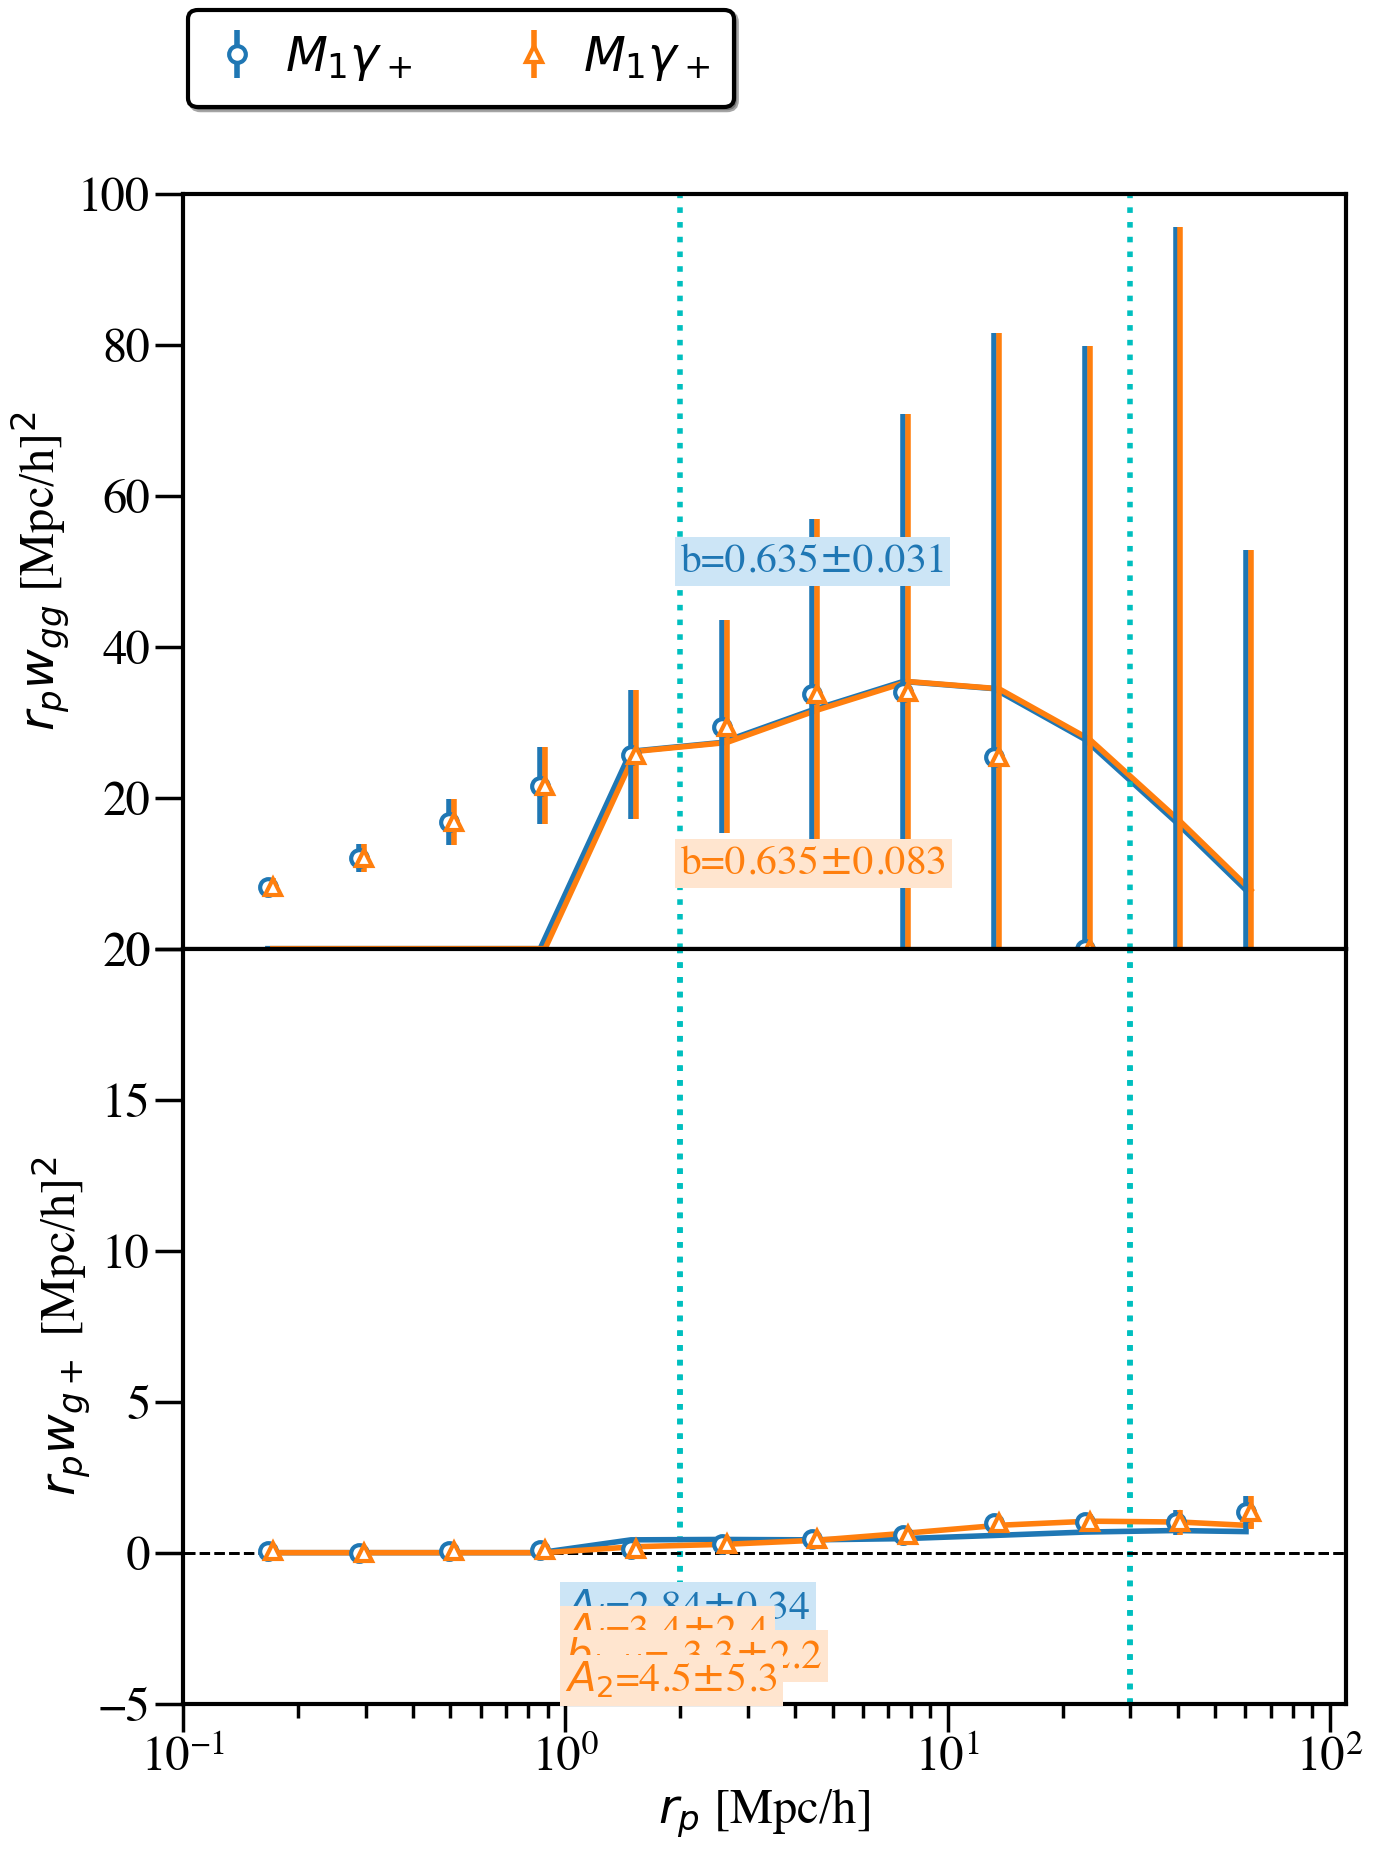

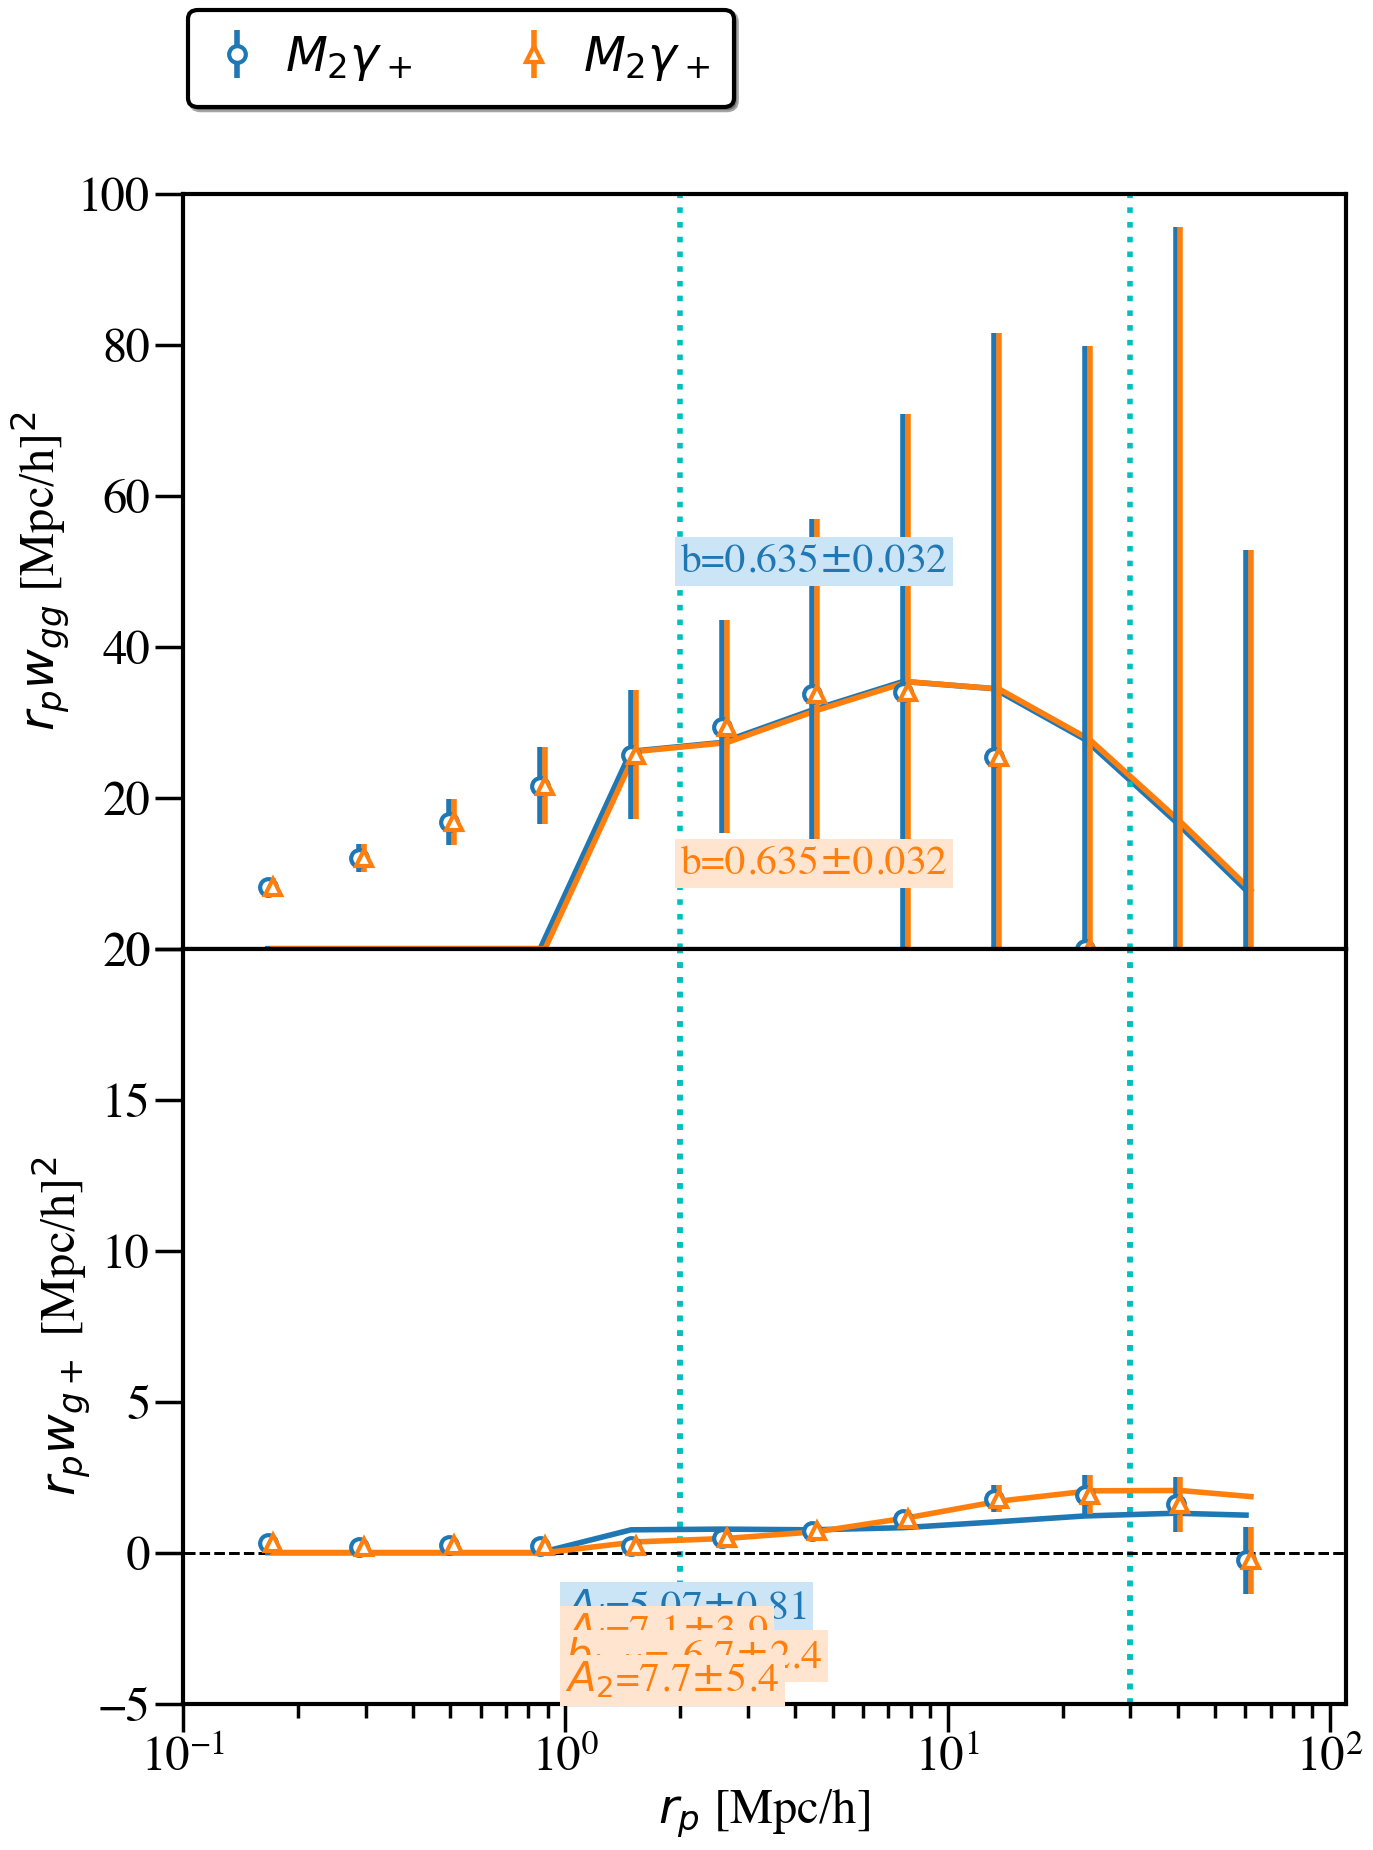

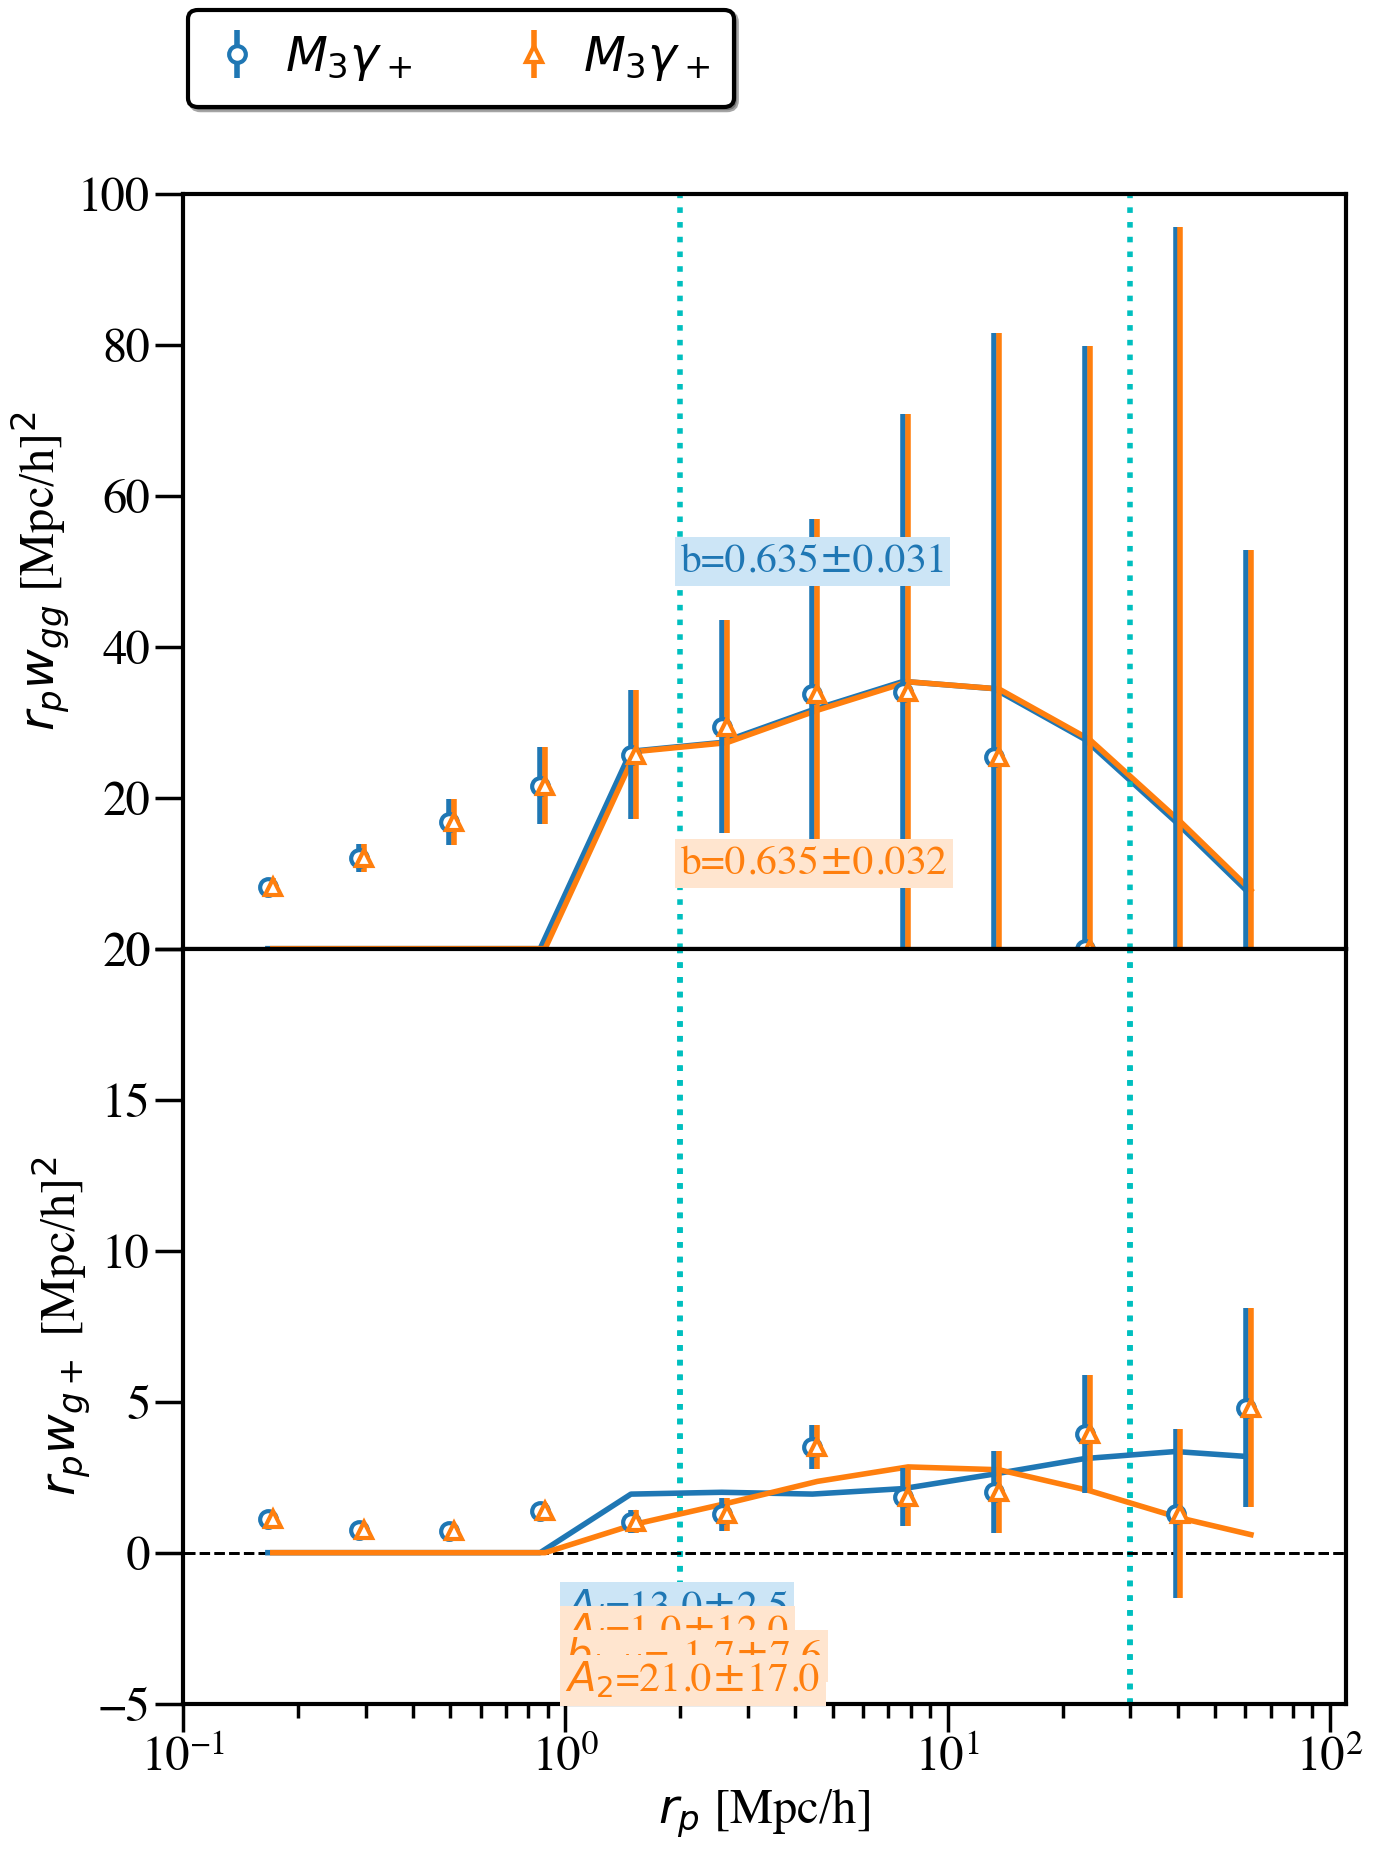

In [44]:
for fn in fns:
    ds={0:DI[fn],1:DI_tatt[fn]}
    plot_corrs(datasets=ds,wgg_ylim=(0.e2,1e2),wgp_ylim=(-5,20),db_y=40,b_y=50,b_x=2,A_y=-2.2,A_x=1,dA_y=.8,
               legend_loc=(0, 1.25),legend_col=2,ti_x=1,ti_y=100)

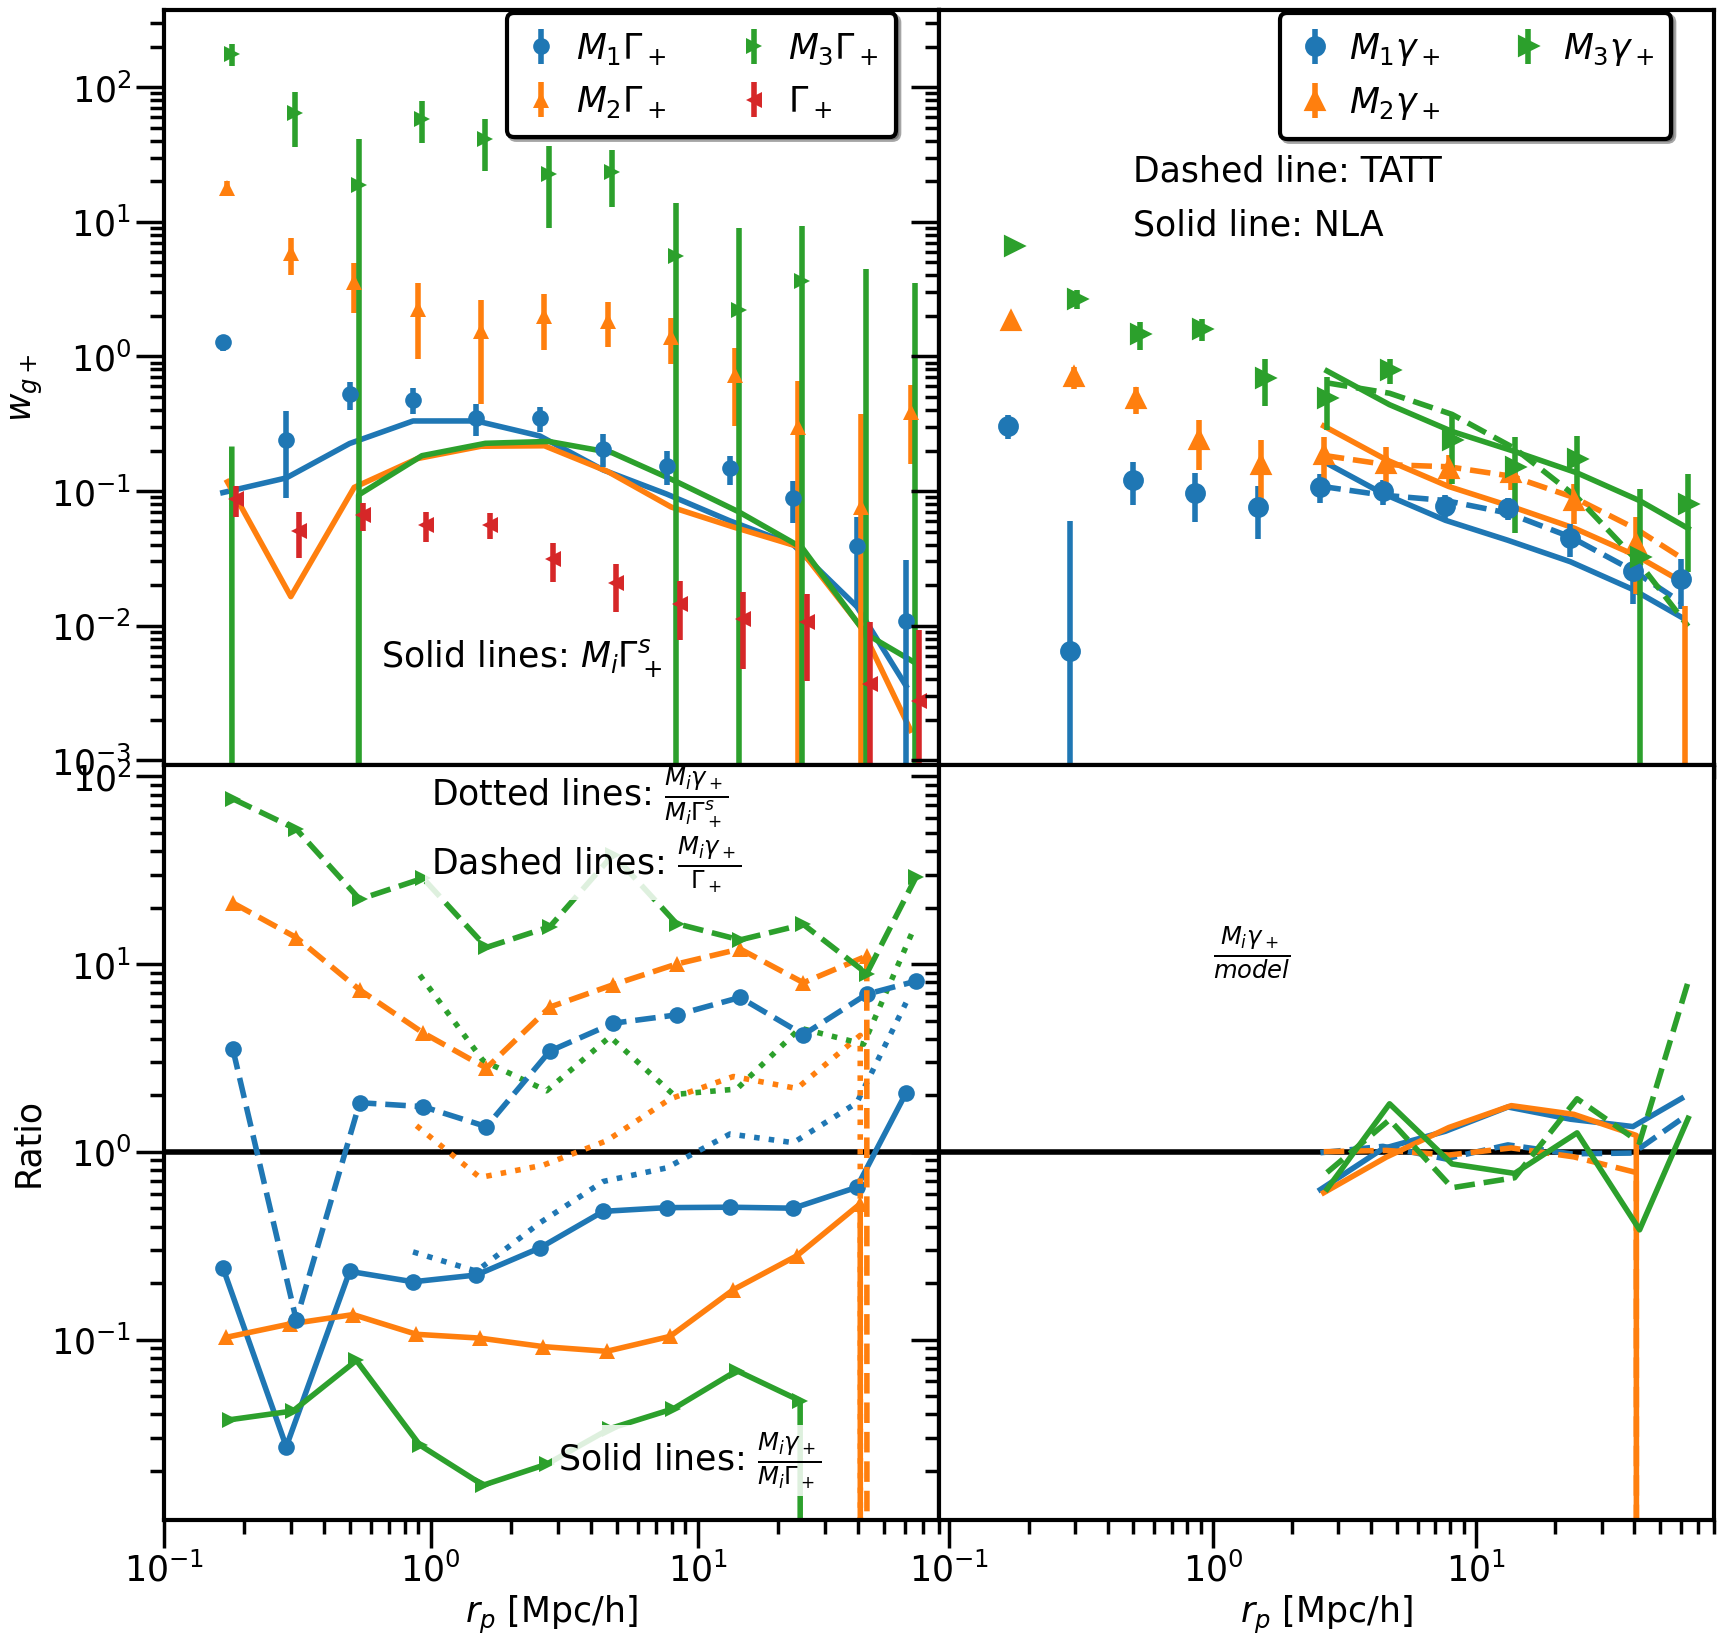

In [73]:
fig,axes0 =subplots(nrows=2, ncols=2, sharex='col', sharey='row',figsize=(20,20))

fns=['{i}tidal_1'.format(i=i) for i in np.arange(4)+1]
fns2=['{i}tidal_0'.format(i=i) for i in np.arange(3)+1]
fns5=['{i}tidal_5'.format(i=i) for i in np.arange(3)+1]
axes=axes0[:,0]
ax=axes[0]
axR=axes[1]
j=0
for fn in fns:
    dd=DI[fn]['dat']['data0']
    mm=DI[fn]['wgp_model']
    mm2=D_tatt[fn]['wgp_model']
    lbl=DI[fn]['label']
    x=dd['1bin_value']>DI[fn]['rp_min']
    ax.errorbar(dd['1bin_value']*(1+0.04*j),dd['6e'],dd['7e_err'],label=lbl,fmt=markers[j],c=colors[j])
#     ax.plot(dd['1bin_value'][x]*(1+0.03*j),mm[x],c=colors[j],zorder=-1)
#     ax.plot(dd['1bin_value'][x]*(1+0.03*j),mm2[x],'--',c=colors[j],zorder=-1)
#     axR.errorbar(dd['1bin_value'][x]*(1+0.03*j),dd['6e'][x]/mm[x],dd['7e_err'][x]/mm[x]*0,label=lbl,fmt=markers[j]+'-',c=colors[j])
#     axR.errorbar(dd['1bin_value'][x]*(1+0.03*j),dd['6e'][x]/mm2[x],dd['7e_err'][x]/mm2[x]*0,label=lbl,fmt=markers[j]+'--',c=colors[j])

    if j<3:
        lbl=''
        dd5=DI[fns5[j]]['dat']['data0']
        ax.errorbar(dd['1bin_value']*(1+0.04*j),dd5['6e'],dd5['7e_err']*0,label=lbl,fmt='-',c=colors[j],mfc='white',mew=3,zorder=-1)
    if j<3:
        mm=DI[fns2[j]]['dat']['data0']['6e']
        x=dd['1bin_value']>0
        axR.errorbar(dd['1bin_value'][x]*(1+0.03*j),mm[x]/dd['6e'][x],dd['7e_err'][x]/mm[x]*0,label=lbl,fmt=markers[j]+'-',c=colors[j])
        x=dd['1bin_value']>0.5
        dd2=DI[fns5[j]]['dat']['data0']
        axR.errorbar(dd['1bin_value'][x]*(1+0.03*j),mm[x]/dd2['6e'][x],dd['7e_err'][x]/mm[x]*0,label=lbl,fmt=':'
                         ,c=colors[j])
        x=dd['1bin_value']>0

    else:
        for j2 in np.arange(3):
            mm=DI[fns2[j2]]['dat']['data0']['6e']
            x=dd['1bin_value']>0
            axR.errorbar(dd['1bin_value'][x]*(1+0.03*j),mm[x]/dd['6e'][x],dd['7e_err'][x]/mm[x]*0,label=lbl,fmt=markers[j2]+'--'
                         ,c=colors[j2])
            
    j+=1
axR.hlines(1,0,100,ls='-',color='k',zorder=-10)
ax.set_xscale('log')
ax.set_yscale('log')
axR.set_yscale('log')
ax.set_ylabel(r'$w_{g+}$',fontsize=25)
axR.set_ylabel(r'Ratio',fontsize=25)
ax.legend(loc='upper right',ncol=2,fontsize=25,bbox_to_anchor=(.95,1.),)
axes[1].set_xlabel(r'$r_p$ [Mpc/h]',fontsize=25)
axR.text(x=3,y=.02,s=r'Solid lines: $\frac{M_i\gamma_+}{M_i\Gamma_+}$',fontsize=25,bbox=dict(facecolor='white', alpha=0.85,lw=0))
axR.text(x=1,y=30,s=r'Dashed lines: $\frac{M_i\gamma_+}{\Gamma_+}$',fontsize=25,bbox=dict(facecolor='white', alpha=0.85,lw=0))
axR.text(x=1,y=70,s=r'Dotted lines: $\frac{M_i\gamma_+}{M_i\Gamma^s_+}$',fontsize=25)
ax.text(x=.65,y=.005,s=r'Solid lines: $M_i\Gamma^s_+$',fontsize=25)
axR.set_xlim(0.1,80)
for ax in axes:
    ax.tick_params(labelsize=25)

axes=axes0[:,1]
ax=axes[0]  
axR=axes[1]
j=0
fns=['{i}tidal_0'.format(i=i) for i in np.arange(3)+1]
for fn in fns:
    dd=DI[fn]['dat']['data0']
    mm=DI[fn]['wgp_model']
    mm2=D_tatt[fn]['wgp_model']
    lbl=DI[fn]['label']
    x=dd['1bin_value']>DI[fn]['rp_min']
    ax.errorbar(dd['1bin_value']*(1+0.03*j),dd['6e'],dd['7e_err'],label=lbl,fmt=markers[j],c=colors[j],mew=3) #mfc='white'
    ax.plot(dd['1bin_value'][x]*(1+0.03*j),mm[x],c=colors[j],zorder=-1)
    ax.plot(dd['1bin_value'][x]*(1+0.03*j),mm2[x],'--',c=colors[j],zorder=-1)
    axR.errorbar(dd['1bin_value'][x]*(1+0.03*j),dd['6e'][x]/mm[x],dd['7e_err'][x]/mm[x]*0,label=lbl,fmt='-',c=colors[j])
    axR.errorbar(dd['1bin_value'][x]*(1+0.03*j),dd['6e'][x]/mm2[x],dd['7e_err'][x]/mm2[x]*0,label=lbl,fmt='--',c=colors[j])
    
    j+=1
ax.set_xscale('log')
ax.legend(loc='upper right',ncol=2,fontsize=25,bbox_to_anchor=(.95,1.),)
ax.text(x=0.5,y=8,s='Solid line: NLA',fontsize=25)
ax.text(x=0.5,y=20,s='Dashed line: TATT',fontsize=25)
axR.text(x=1,y=10,s=r'$\frac{M_i\gamma_+}{{model}}$',fontsize=25)
axes[1].set_xlabel(r'$r_p$ [Mpc/h]',fontsize=25)
axR.hlines(1,0,100,ls='-',color='k',zorder=-10)
for ax in axes:
    ax.tick_params(labelsize=25)
axR.set_xlim(0.091,80)
fname='mb2_wgp.'+fig_format
fig.savefig(fig_home+fname,format=fig_format,bbox_inches='tight')
show()

In [46]:
from matplotlib import rc
rc('text', usetex=False)
rc('font', family = 'san-serif')

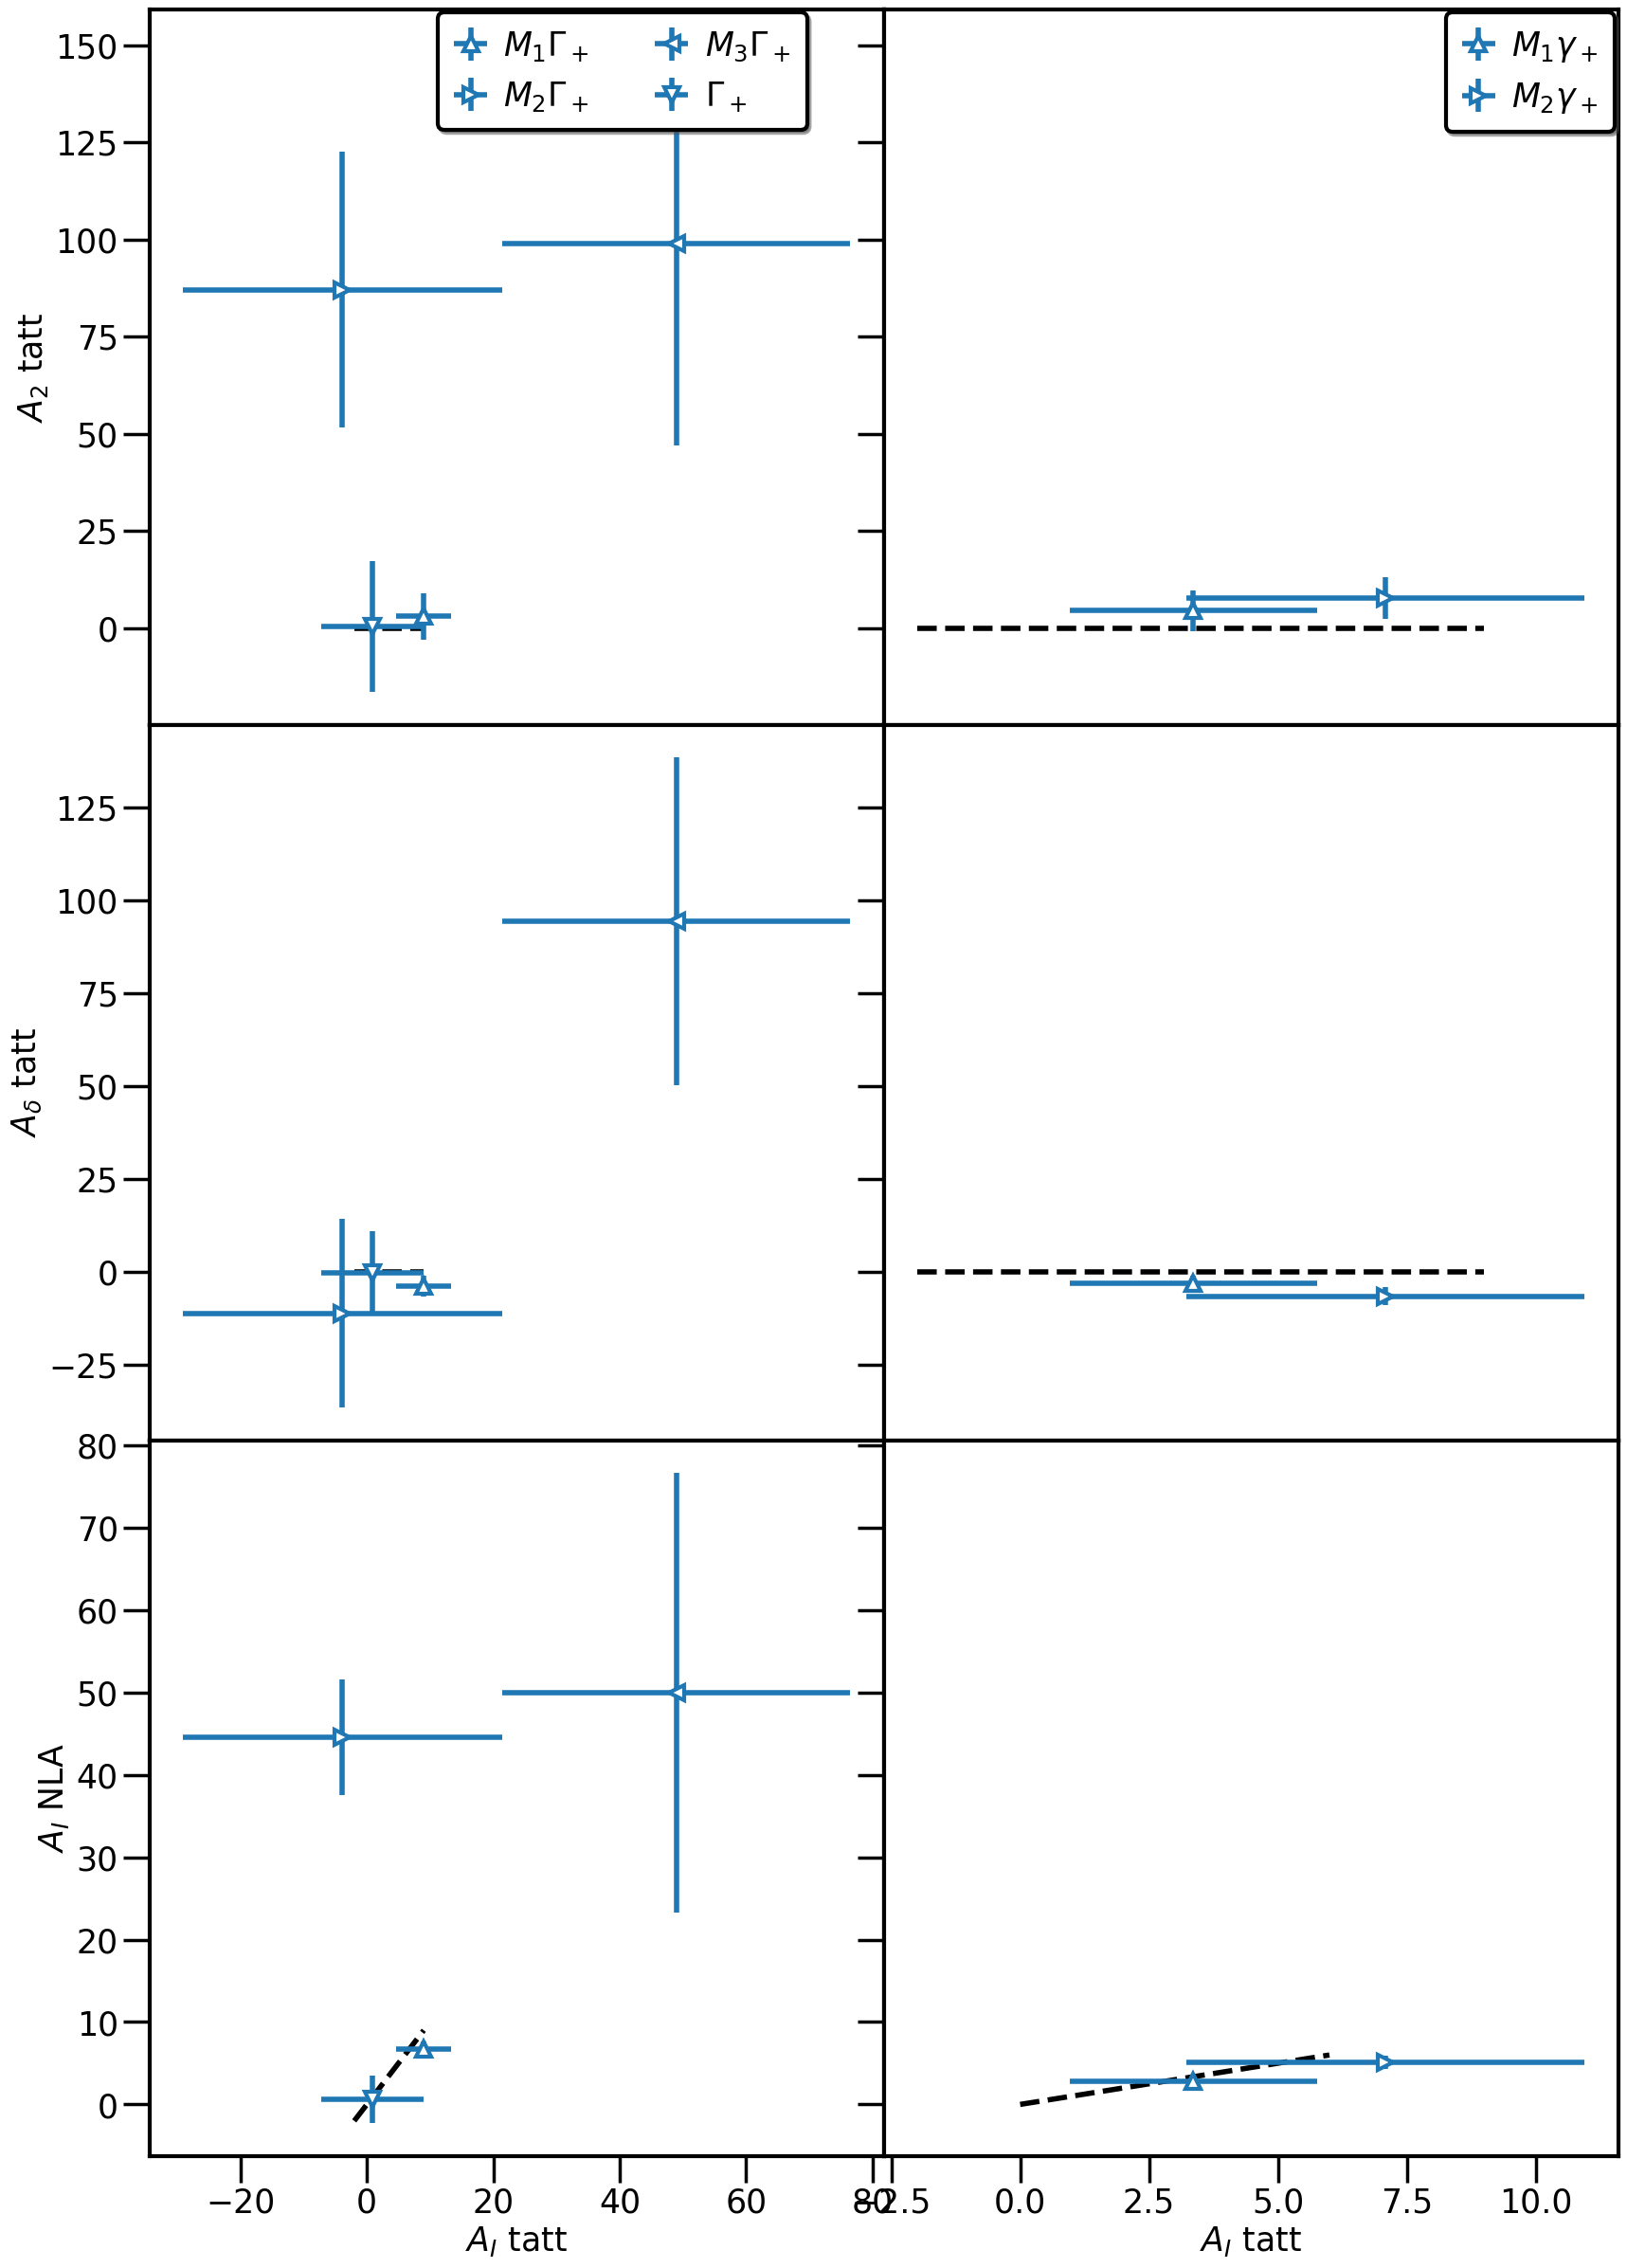

In [48]:
fig,axes0 =subplots(nrows=3, ncols=2, sharex='col', sharey='row',figsize=(20,30))
fns={0:['{i}tidal_1'.format(i=i) for i in np.arange(4)+1]}

axes=axes0[:,0]
p1=1
p2=1

ax=axes[2]

for i in fns.keys():
    color=colors[i]
    j=1
    for k in fns[i]:
        lbl=''
        mfc='white'
        if i==2:
#             mfc=None
            j=0
        if i<2:
            lbl=D_tatt[k]['label']
        ax.errorbar(D_tatt[k]['params']['jk'][p2],DI[k]['params']['jk'][p1],yerr=DI[k]['params']['jk_err'][p1],
             xerr=D_tatt[k]['params']['jk_err'][p2],label=lbl,color=color,fmt=markers[j],mew=3,mfc=mfc)
        j+=1
ax.set_ylabel('$A_I$ NLA',fontsize=25)
x=np.linspace(-2,9,10)
ax.plot(x,x,'k--',zorder=-1)

ax=axes[1]
p2=2
for i in fns.keys():
    color=colors[i]
    j=1
    for k in fns[i]:
        lbl=''
        mfc='white'
        if i==2:
#             mfc=None
            j=0
        if i==3:
            lbl=D_tatt[k]['label']
        ax.errorbar(D_tatt[k]['params']['jk'][p1],D_tatt[k]['params']['jk'][p2],xerr=D_tatt[k]['params']['jk_err'][p1],
             yerr=D_tatt[k]['params']['jk_err'][p2],label=lbl,color=color,fmt=markers[j],mew=3,mfc=mfc)
        j+=1
ax.set_ylabel('$A_\delta$ tatt',fontsize=25)
# k=fns[2][0]
# ax.hist2d(D_tatt[k]['params']['p'][:,p1],D_tatt[k]['params']['p'][:,p2],50,cmap='Reds',alpha=0.4)

ax=axes[0]
p2=3
for i in fns.keys():
    color=colors[i]
    j=1
    for k in fns[i]:
        lbl=''
        mfc='white'
        if i==2:
#             mfc=None
            j=0
        if i==0 :#and j==0:
            lbl=D_tatt[k]['label']
        ax.errorbar(D_tatt[k]['params']['jk'][p1],D_tatt[k]['params']['jk'][p2],xerr=D_tatt[k]['params']['jk_err'][p1],
             yerr=D_tatt[k]['params']['jk_err'][p2],label=lbl,color=color,fmt=markers[j],mew=3,mfc=mfc)
        j+=1
# k=fns[2][0]
# ax.hist2d(D_tatt[k]['params']['p'][:,p1],D_tatt[k]['params']['p'][:,p2],50,cmap='Reds',alpha=0.4)
ax.set_ylabel('$A_2$ tatt',fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=25)
axes[0].hlines(0,-2,9,ls='--',color='k',zorder=-10)
axes[1].hlines(0,-2,9,ls='--',color='k',zorder=-10)

axes[0].legend(loc='upper right',ncol=2,bbox_to_anchor=(.9,1.),
               facecolor='white', framealpha=1,edgecolor='black',fontsize=25)
# axes[1].legend(loc='lower right',ncol=1,bbox_to_anchor=(.9,0),
#                facecolor='white', framealpha=1,edgecolor='black',fontsize=25)
axes[2].set_xlabel('$A_I$ tatt',fontsize=25)
# axes[2].set_xlim(-2,9)
#####################
fns={0:['{i}tidal_0'.format(i=i) for i in np.arange(2)+1]}


p1=1
p2=1
axes=axes0[:,1]
ax=axes[2]

for i in fns.keys():
    color=colors[i]
    j=1
    for k in fns[i]:
        lbl=''
        mfc='white'
        if i==2:
#             mfc=None
            j=0
        if i<2:
            lbl=D_tatt[k]['label']
        ax.errorbar(D_tatt[k]['params']['jk'][p2],DI[k]['params']['jk'][p1],yerr=DI[k]['params']['jk_err'][p1],
             xerr=D_tatt[k]['params']['jk_err'][p2],label=lbl,color=color,fmt=markers[j],mew=3,mfc=mfc)
        j+=1

x=np.linspace(0,6,10)
ax.plot(x,x,'k--',zorder=-1)

ax=axes[1]
p2=2
for i in fns.keys():
    color=colors[i]
    j=1
    for k in fns[i]:
        lbl=''
        mfc='white'
        if i==2:
#             mfc=None
            j=0
#         if i<=1:
#             lbl=C_tatt[k]['label']
        ax.errorbar(D_tatt[k]['params']['jk'][p1],D_tatt[k]['params']['jk'][p2],xerr=D_tatt[k]['params']['jk_err'][p1],
             yerr=D_tatt[k]['params']['jk_err'][p2],label=lbl,color=color,fmt=markers[j],mew=3,mfc=mfc)
        j+=1
# k=fns[2][0]
# ax.hist2d(D_tatt[k]['params']['p'][:,p1],D_tatt[k]['params']['p'][:,p2],50,cmap='Reds',alpha=0.4)
for ax in axes:
    ax.tick_params(labelsize=25)


ax=axes[0]
p2=3
for i in fns.keys():
    color=colors[i]
    j=1
    for k in fns[i]:
        lbl=''
        mfc='white'
        if i==2:
#             mfc=None
            j=0
        if i==0:
            lbl=D_tatt[k]['label']
        ax.errorbar(D_tatt[k]['params']['jk'][p1],D_tatt[k]['params']['jk'][p2],xerr=D_tatt[k]['params']['jk_err'][p1],
             yerr=D_tatt[k]['params']['jk_err'][p2],label=lbl,color=color,fmt=markers[j],mew=3,mfc=mfc)
        j+=1
# k=fns[2][0]
# ax.hist2d(D_tatt[k]['params']['p'][:,p1],D_tatt[k]['params']['p'][:,p2],50,cmap='Reds',alpha=0.4)
    
axes[0].hlines(0,-2,9,ls='--',color='k',zorder=-10)
axes[1].hlines(0,-2,9,ls='--',color='k',zorder=-10)

# axes[2].set_xlim(-2.2,9)
# axes[2].set_ylim(0,8.2)
# axes[1].set_ylim(-9.5,4.5)
# axes[0].set_ylim(-7,21.5)
axes[2].set_xlabel('$A_I$ tatt',fontsize=25)
# axes[2].legend(loc='upper right',ncol=4,bbox_to_anchor=(1,1.25),
#                facecolor='white', framealpha=1,edgecolor='black',fontsize=25)
# axes[1].legend(loc='lower right',ncol=2,#bbox_to_anchor=(.0,1.),
#                facecolor='white', framealpha=1,edgecolor='black',fontsize=25)
axes[0].legend(loc='upper right',ncol=1,#bbox_to_anchor=(.0,1.),
               facecolor='white', framealpha=1,edgecolor='black',fontsize=25)
fname='mb2_nla_tatt.'+fig_format
# savefig(fig_home+fname,format=fig_format,bbox_inches='tight')
show()